In [ ]:
from hamiltonian_nn.hnn import HNN                  # Sam Greydanus repo file
from hamiltonian_nn.nn_models import MLP            # 3-layer MLP the repo already uses
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gym
from torchvision import transforms
from PIL import Image, ImageDraw

In [4]:
def compute_energy(theta, omega, m=1.0, l=1.0, g=9.81):
    """
    Compute the total mechanical energy of the pendulum
    E = 0.5 * m * l^2 * omega^2 + m * g * l * (1 - cos(theta))
    """
    kinetic = 0.5 * m * (l**2) * omega**2
    potential = m * g * l * (1 - np.cos(theta))
    return kinetic + potential

In [5]:
def plot_energy_per_episode(dataset, episode_length=100):
    thetas = []
    omegas = []
    energies = []
    num_episodes = len(dataset) // episode_length

    for ep in range(num_episodes):
        ep_thetas = []
        ep_omegas = []
        for i in range(episode_length):
            idx = ep * episode_length + i
            _, label = dataset[idx]
            ep_thetas.append(label[0].item())
            ep_omegas.append(label[1].item())
        theta_np = np.array(ep_thetas)
        omega_np = np.array(ep_omegas)
        energy = compute_energy(theta_np, omega_np)
        energies.append(energy)

    # Plot each episode separately
    plt.figure(figsize=(12, 4))
    for ep_energy in energies:
        plt.plot(ep_energy, alpha=0.7)
    plt.xlabel("Time Step (within episode)")
    plt.ylabel("Energy (J)")
    plt.title("Pendulum Energy per Episode")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("energy_per_episode.png")
    plt.show()


In [6]:
def plot_true_phase_space(dataset, num_samples=500):
    theta_vals = []
    omega_vals = []
    for i in range(min(num_samples, len(dataset))):
        _, label = dataset[i]
        theta_vals.append(label[0].item())
        omega_vals.append(label[1].item())

    plt.figure(figsize=(6, 5))
    plt.plot(theta_vals, omega_vals, '.', alpha=0.3)
    plt.xlabel("Theta (rad)")
    plt.ylabel("Theta dot (rad/s)")
    plt.title("True Phase Space Trajectory (θ vs θ̇)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("true_phase_space.png")
    plt.show()

In [7]:
def analyze_vjepa_latent_phase_relation(model, dataset, batch_size=64, num_samples=500):
    """
    Analyze how V-JEPA latent embeddings relate to physical phase space variables (theta, theta_dot).
    This assumes access to the latent features before the prediction head.

    Args:
        model: trained V-JEPA model
        dataset: PendulumDataset object with access to raw images and (theta, omega) tuples
        batch_size: batch size for DataLoader
        num_samples: number of samples to analyze
    """
    model.eval()

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    latent_features = []
    theta_list = []
    omega_list = []

    count = 0
    for imgs, labels in tqdm(loader, desc="Extracting embeddings"):
        imgs = imgs.to(next(model.parameters()).device)
        thetas, omegas = labels[:, 0], labels[:, 1]

        with torch.no_grad():
            x = model.patch_embed(imgs) + model.pos_embed  # [B, N, D]
            x = model.context_encoder(x)  # [B, N, D]
            pooled = x.mean(dim=1)  # average pooling over patches -> [B, D]
            latent_features.append(pooled.cpu())

        theta_list.extend(thetas.numpy())
        omega_list.extend(omegas.numpy())

        count += imgs.size(0)
        if count >= num_samples:
            break

    latent_features = torch.cat(latent_features, dim=0).numpy()[:num_samples]
    theta_array = np.array(theta_list[:num_samples]).reshape(-1, 1)
    omega_array = np.array(omega_list[:num_samples]).reshape(-1, 1)

    # Fit regressors
    reg_theta = LinearRegression().fit(latent_features, theta_array)
    reg_omega = LinearRegression().fit(latent_features, omega_array)

    theta_pred = reg_theta.predict(latent_features)
    omega_pred = reg_omega.predict(latent_features)

    # Metrics
    r2_theta = r2_score(theta_array, theta_pred)
    r2_omega = r2_score(omega_array, omega_pred)
    mse_theta = mean_squared_error(theta_array, theta_pred)
    mse_omega = mean_squared_error(omega_array, omega_pred)

    print(f"\nLatent -> Theta R²: {r2_theta:.4f}, MSE: {mse_theta:.4f}")
    print(f"Latent -> Omega R²: {r2_omega:.4f}, MSE: {mse_omega:.4f}")

    # Scatter plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(theta_array, theta_pred, alpha=0.6)
    plt.xlabel("True θ")
    plt.ylabel("Predicted θ from Latents")
    plt.title("Latent Embedding → Theta")

    plt.subplot(1, 2, 2)
    plt.scatter(omega_array, omega_pred, alpha=0.6)
    plt.xlabel("True θ̇")
    plt.ylabel("Predicted θ̇ from Latents")
    plt.title("Latent Embedding → Theta_dot")

    plt.tight_layout()
    plt.show()


Using device: cpu
Generating synthetic pendulum data...


  0%|          | 0/50 [00:00<?, ?it/s]/Users/panaschristou/miniforge3/envs/sys_dev/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 50/50 [00:00<00:00, 171.31it/s]


Dataset created with 5000 images
Starting training…


Epoch 1/10:   1%|          | 1/157 [00:01<04:04,  1.57s/batch]

  step 0000  jepa 6.6744  phys 12.6870


Epoch 1/10:   7%|▋         | 11/157 [00:12<02:28,  1.02s/batch]

  step 0010  jepa 4.0879  phys 11.2308


Epoch 1/10:  13%|█▎        | 21/157 [00:22<02:22,  1.05s/batch]

  step 0020  jepa 3.7061  phys 12.1956


Epoch 1/10:  20%|█▉        | 31/157 [00:35<02:55,  1.39s/batch]

  step 0030  jepa 3.2914  phys 14.9916


Epoch 1/10:  26%|██▌       | 41/157 [00:47<02:22,  1.23s/batch]

  step 0040  jepa 2.9035  phys 13.4320


Epoch 1/10:  32%|███▏      | 51/157 [00:59<01:56,  1.10s/batch]

  step 0050  jepa 2.5216  phys 12.5829


Epoch 1/10:  39%|███▉      | 61/157 [01:10<01:42,  1.06s/batch]

  step 0060  jepa 2.1753  phys 14.8146


Epoch 1/10:  45%|████▌     | 71/157 [01:20<01:25,  1.01batch/s]

  step 0070  jepa 1.8865  phys 7.6687


Epoch 1/10:  52%|█████▏    | 81/157 [01:30<01:16,  1.01s/batch]

  step 0080  jepa 1.6983  phys 5.4741


Epoch 1/10:  58%|█████▊    | 91/157 [01:40<01:05,  1.01batch/s]

  step 0090  jepa 1.5432  phys 11.3039


Epoch 1/10:  64%|██████▍   | 101/157 [01:50<00:55,  1.02batch/s]

  step 0100  jepa 1.4496  phys 11.2730


Epoch 1/10:  71%|███████   | 111/157 [02:00<00:45,  1.00batch/s]

  step 0110  jepa 1.3801  phys 15.4362


Epoch 1/10:  77%|███████▋  | 121/157 [02:09<00:35,  1.03batch/s]

  step 0120  jepa 1.3348  phys 14.3269


Epoch 1/10:  83%|████████▎ | 131/157 [02:19<00:25,  1.02batch/s]

  step 0130  jepa 1.2991  phys 13.4191


Epoch 1/10:  90%|████████▉ | 141/157 [02:29<00:15,  1.01batch/s]

  step 0140  jepa 1.2848  phys 9.1446


Epoch 1/10:  96%|█████████▌| 151/157 [02:39<00:05,  1.01batch/s]

  step 0150  jepa 1.2776  phys 16.6309


Epoch 1/10: 100%|██████████| 157/157 [02:44<00:00,  1.05s/batch]


Epoch 1 complete — avg loss 2.2683


Epoch 2/10:   1%|          | 1/157 [00:01<02:43,  1.05s/batch]

  step 0000  jepa 1.2570  phys 13.0413


Epoch 2/10:   7%|▋         | 11/157 [00:10<02:25,  1.01batch/s]

  step 0010  jepa 1.2512  phys 12.0327


Epoch 2/10:  13%|█▎        | 21/157 [00:20<02:15,  1.01batch/s]

  step 0020  jepa 1.2365  phys 14.5234


Epoch 2/10:  20%|█▉        | 31/157 [00:30<02:03,  1.02batch/s]

  step 0030  jepa 1.2306  phys 7.4452


Epoch 2/10:  26%|██▌       | 41/157 [00:40<01:53,  1.02batch/s]

  step 0040  jepa 1.2194  phys 7.1836


Epoch 2/10:  32%|███▏      | 51/157 [00:50<01:43,  1.03batch/s]

  step 0050  jepa 1.2302  phys 15.6003


Epoch 2/10:  39%|███▉      | 61/157 [01:00<01:34,  1.02batch/s]

  step 0060  jepa 1.1984  phys 9.9708


Epoch 2/10:  45%|████▌     | 71/157 [01:10<01:25,  1.00batch/s]

  step 0070  jepa 1.2042  phys 10.7502


Epoch 2/10:  52%|█████▏    | 81/157 [01:20<01:18,  1.03s/batch]

  step 0080  jepa 1.1743  phys 15.7733


Epoch 2/10:  58%|█████▊    | 91/157 [01:30<01:05,  1.01batch/s]

  step 0090  jepa 1.1609  phys 10.0081


Epoch 2/10:  64%|██████▍   | 101/157 [01:40<00:55,  1.01batch/s]

  step 0100  jepa 1.1565  phys 12.4168


Epoch 2/10:  71%|███████   | 111/157 [01:50<00:44,  1.02batch/s]

  step 0110  jepa 1.1494  phys 16.5670


Epoch 2/10:  77%|███████▋  | 121/157 [02:00<00:35,  1.01batch/s]

  step 0120  jepa 1.1315  phys 11.8603


Epoch 2/10:  83%|████████▎ | 131/157 [02:10<00:25,  1.02batch/s]

  step 0130  jepa 1.1272  phys 9.9457


Epoch 2/10:  90%|████████▉ | 141/157 [02:20<00:16,  1.03s/batch]

  step 0140  jepa 1.1225  phys 11.1913


Epoch 2/10:  96%|█████████▌| 151/157 [02:30<00:05,  1.02batch/s]

  step 0150  jepa 1.1064  phys 13.9374


Epoch 2/10: 100%|██████████| 157/157 [02:35<00:00,  1.01batch/s]


Epoch 2 complete — avg loss 1.1987


Epoch 3/10:   1%|          | 1/157 [00:00<02:31,  1.03batch/s]

  step 0000  jepa 1.1305  phys 9.2558


Epoch 3/10:   7%|▋         | 11/157 [00:10<02:23,  1.01batch/s]

  step 0010  jepa 1.0989  phys 10.1389


Epoch 3/10:  13%|█▎        | 21/157 [00:20<02:13,  1.02batch/s]

  step 0020  jepa 1.1050  phys 11.7800


Epoch 3/10:  20%|█▉        | 31/157 [00:30<02:05,  1.00batch/s]

  step 0030  jepa 1.0945  phys 12.7500


Epoch 3/10:  26%|██▌       | 41/157 [00:40<01:54,  1.01batch/s]

  step 0040  jepa 1.0772  phys 14.0412


Epoch 3/10:  32%|███▏      | 51/157 [00:51<01:49,  1.04s/batch]

  step 0050  jepa 1.0908  phys 11.9028


Epoch 3/10:  39%|███▉      | 61/157 [01:01<01:34,  1.01batch/s]

  step 0060  jepa 1.0812  phys 11.2369


Epoch 3/10:  45%|████▌     | 71/157 [01:11<01:25,  1.00batch/s]

  step 0070  jepa 1.0697  phys 12.8889


Epoch 3/10:  52%|█████▏    | 81/157 [01:20<01:14,  1.02batch/s]

  step 0080  jepa 1.0685  phys 10.4936


Epoch 3/10:  58%|█████▊    | 91/157 [01:31<01:07,  1.02s/batch]

  step 0090  jepa 1.0794  phys 12.0602


Epoch 3/10:  64%|██████▍   | 101/157 [01:41<00:55,  1.00batch/s]

  step 0100  jepa 1.0720  phys 14.2368


Epoch 3/10:  71%|███████   | 111/157 [01:51<00:46,  1.00s/batch]

  step 0110  jepa 1.0560  phys 12.2799


Epoch 3/10:  77%|███████▋  | 121/157 [02:01<00:35,  1.01batch/s]

  step 0120  jepa 1.0773  phys 16.3502


Epoch 3/10:  83%|████████▎ | 131/157 [02:11<00:25,  1.02batch/s]

  step 0130  jepa 1.0672  phys 9.3938


Epoch 3/10:  90%|████████▉ | 141/157 [02:21<00:16,  1.04s/batch]

  step 0140  jepa 1.0575  phys 13.8783


Epoch 3/10:  96%|█████████▌| 151/157 [02:31<00:06,  1.00s/batch]

  step 0150  jepa 1.0796  phys 10.4135


Epoch 3/10: 100%|██████████| 157/157 [02:36<00:00,  1.00batch/s]


Epoch 3 complete — avg loss 1.0916


Epoch 4/10:   1%|          | 1/157 [00:00<02:35,  1.01batch/s]

  step 0000  jepa 1.0696  phys 12.3960


Epoch 4/10:   7%|▋         | 11/157 [00:11<02:33,  1.05s/batch]

  step 0010  jepa 1.0644  phys 12.7488


Epoch 4/10:  13%|█▎        | 21/157 [00:21<02:14,  1.01batch/s]

  step 0020  jepa 1.0550  phys 13.4849


Epoch 4/10:  20%|█▉        | 31/157 [00:31<02:03,  1.02batch/s]

  step 0030  jepa 1.0526  phys 15.4744


Epoch 4/10:  26%|██▌       | 41/157 [00:41<01:55,  1.00batch/s]

  step 0040  jepa 1.0577  phys 13.1281


Epoch 4/10:  32%|███▏      | 51/157 [00:50<01:43,  1.02batch/s]

  step 0050  jepa 1.0641  phys 12.4595


Epoch 4/10:  39%|███▉      | 61/157 [01:00<01:34,  1.02batch/s]

  step 0060  jepa 1.0568  phys 12.7684


Epoch 4/10:  45%|████▌     | 71/157 [01:10<01:24,  1.01batch/s]

  step 0070  jepa 1.0469  phys 14.7100


Epoch 4/10:  52%|█████▏    | 81/157 [01:20<01:14,  1.03batch/s]

  step 0080  jepa 1.0650  phys 9.5094


Epoch 4/10:  58%|█████▊    | 91/157 [01:30<01:05,  1.01batch/s]

  step 0090  jepa 1.0589  phys 12.6508


Epoch 4/10:  64%|██████▍   | 101/157 [01:40<00:55,  1.01batch/s]

  step 0100  jepa 1.0490  phys 12.3336


Epoch 4/10:  71%|███████   | 111/157 [01:50<00:46,  1.02s/batch]

  step 0110  jepa 1.0542  phys 8.8192


Epoch 4/10:  77%|███████▋  | 121/157 [02:00<00:35,  1.02batch/s]

  step 0120  jepa 1.0516  phys 12.7952


Epoch 4/10:  83%|████████▎ | 131/157 [02:09<00:26,  1.00s/batch]

  step 0130  jepa 1.0523  phys 13.0829


Epoch 4/10:  90%|████████▉ | 141/157 [02:20<00:17,  1.07s/batch]

  step 0140  jepa 1.0513  phys 9.4853


Epoch 4/10:  96%|█████████▌| 151/157 [02:31<00:06,  1.05s/batch]

  step 0150  jepa 1.0460  phys 12.6348


Epoch 4/10: 100%|██████████| 157/157 [02:36<00:00,  1.00batch/s]


Epoch 4 complete — avg loss 1.0668


Epoch 5/10:   1%|          | 1/157 [00:01<02:38,  1.01s/batch]

  step 0000  jepa 1.0473  phys 15.5088


Epoch 5/10:   7%|▋         | 11/157 [00:10<02:24,  1.01batch/s]

  step 0010  jepa 1.0416  phys 6.4078


Epoch 5/10:  13%|█▎        | 21/157 [00:20<02:13,  1.02batch/s]

  step 0020  jepa 1.0465  phys 17.0321


Epoch 5/10:  20%|█▉        | 31/157 [00:31<02:07,  1.01s/batch]

  step 0030  jepa 1.0450  phys 16.1715


Epoch 5/10:  26%|██▌       | 41/157 [00:40<01:53,  1.02batch/s]

  step 0040  jepa 1.0411  phys 10.8377


Epoch 5/10:  32%|███▏      | 51/157 [00:51<01:48,  1.03s/batch]

  step 0050  jepa 1.0380  phys 15.5140


Epoch 5/10:  39%|███▉      | 61/157 [01:00<01:34,  1.02batch/s]

  step 0060  jepa 1.0400  phys 17.0143


Epoch 5/10:  45%|████▌     | 71/157 [01:11<01:32,  1.07s/batch]

  step 0070  jepa 1.0370  phys 15.4827


Epoch 5/10:  52%|█████▏    | 81/157 [01:21<01:22,  1.08s/batch]

  step 0080  jepa 1.0443  phys 13.2859


Epoch 5/10:  58%|█████▊    | 91/157 [01:32<01:07,  1.03s/batch]

  step 0090  jepa 1.0355  phys 14.4607


Epoch 5/10:  64%|██████▍   | 101/157 [01:42<00:54,  1.03batch/s]

  step 0100  jepa 1.0408  phys 12.2806


Epoch 5/10:  71%|███████   | 111/157 [01:52<00:45,  1.02batch/s]

  step 0110  jepa 1.0360  phys 13.8428


Epoch 5/10:  77%|███████▋  | 121/157 [02:02<00:36,  1.01s/batch]

  step 0120  jepa 1.0454  phys 11.4627


Epoch 5/10:  83%|████████▎ | 131/157 [02:12<00:25,  1.01batch/s]

  step 0130  jepa 1.0379  phys 6.2662


Epoch 5/10:  90%|████████▉ | 141/157 [02:22<00:15,  1.01batch/s]

  step 0140  jepa 1.0390  phys 14.5644


Epoch 5/10:  96%|█████████▌| 151/157 [02:32<00:05,  1.02batch/s]

  step 0150  jepa 1.0402  phys 9.8788


Epoch 5/10: 100%|██████████| 157/157 [02:37<00:00,  1.00s/batch]


Epoch 5 complete — avg loss 1.0549


Epoch 6/10:   1%|          | 1/157 [00:00<02:34,  1.01batch/s]

  step 0000  jepa 1.0400  phys 9.3818


Epoch 6/10:   7%|▋         | 11/157 [00:10<02:23,  1.02batch/s]

  step 0010  jepa 1.0454  phys 18.0283


Epoch 6/10:  13%|█▎        | 21/157 [00:20<02:12,  1.02batch/s]

  step 0020  jepa 1.0402  phys 7.0456


Epoch 6/10:  20%|█▉        | 31/157 [00:30<02:04,  1.01batch/s]

  step 0030  jepa 1.0347  phys 9.9888


Epoch 6/10:  26%|██▌       | 41/157 [00:40<01:54,  1.02batch/s]

  step 0040  jepa 1.0458  phys 11.9506


Epoch 6/10:  32%|███▏      | 51/157 [00:50<01:44,  1.02batch/s]

  step 0050  jepa 1.0363  phys 14.0589


Epoch 6/10:  39%|███▉      | 61/157 [01:00<01:34,  1.02batch/s]

  step 0060  jepa 1.0431  phys 13.1423


Epoch 6/10:  45%|████▌     | 71/157 [01:10<01:24,  1.02batch/s]

  step 0070  jepa 1.0347  phys 10.9393


Epoch 6/10:  52%|█████▏    | 81/157 [01:20<01:15,  1.01batch/s]

  step 0080  jepa 1.0245  phys 11.4979


Epoch 6/10:  58%|█████▊    | 91/157 [01:30<01:04,  1.02batch/s]

  step 0090  jepa 1.0329  phys 11.8450


Epoch 6/10:  64%|██████▍   | 101/157 [01:40<00:55,  1.00batch/s]

  step 0100  jepa 1.0350  phys 7.4854


Epoch 6/10:  71%|███████   | 111/157 [01:50<00:45,  1.00batch/s]

  step 0110  jepa 1.0339  phys 8.4010


Epoch 6/10:  77%|███████▋  | 121/157 [02:00<00:35,  1.01batch/s]

  step 0120  jepa 1.0270  phys 13.1258


Epoch 6/10:  83%|████████▎ | 131/157 [02:10<00:25,  1.02batch/s]

  step 0130  jepa 1.0339  phys 11.6383


Epoch 6/10:  90%|████████▉ | 141/157 [02:20<00:16,  1.03s/batch]

  step 0140  jepa 1.0338  phys 9.4718


Epoch 6/10:  96%|█████████▌| 151/157 [02:30<00:05,  1.02batch/s]

  step 0150  jepa 1.0355  phys 14.0155


Epoch 6/10: 100%|██████████| 157/157 [02:35<00:00,  1.01batch/s]


Epoch 6 complete — avg loss 1.0467


Epoch 7/10:   1%|          | 1/157 [00:01<02:50,  1.09s/batch]

  step 0000  jepa 1.0423  phys 11.3074


Epoch 7/10:   7%|▋         | 11/157 [00:11<02:25,  1.00batch/s]

  step 0010  jepa 1.0333  phys 13.8471


Epoch 7/10:  13%|█▎        | 21/157 [00:21<02:16,  1.00s/batch]

  step 0020  jepa 1.0235  phys 14.8370


Epoch 7/10:  20%|█▉        | 31/157 [00:31<02:04,  1.01batch/s]

  step 0030  jepa 1.0357  phys 9.8876


Epoch 7/10:  26%|██▌       | 41/157 [00:41<01:56,  1.01s/batch]

  step 0040  jepa 1.0170  phys 14.3476


Epoch 7/10:  32%|███▏      | 51/157 [00:51<01:43,  1.02batch/s]

  step 0050  jepa 1.0226  phys 15.9426


Epoch 7/10:  39%|███▉      | 61/157 [01:01<01:35,  1.00batch/s]

  step 0060  jepa 1.0288  phys 13.9667


Epoch 7/10:  45%|████▌     | 71/157 [01:10<01:24,  1.02batch/s]

  step 0070  jepa 1.0353  phys 12.1174


Epoch 7/10:  52%|█████▏    | 81/157 [01:20<01:15,  1.01batch/s]

  step 0080  jepa 1.0252  phys 10.2300


Epoch 7/10:  58%|█████▊    | 91/157 [01:30<01:05,  1.00batch/s]

  step 0090  jepa 1.0191  phys 13.2577


Epoch 7/10:  64%|██████▍   | 101/157 [01:40<00:55,  1.00batch/s]

  step 0100  jepa 1.0260  phys 10.8768


Epoch 7/10:  71%|███████   | 111/157 [01:50<00:46,  1.01s/batch]

  step 0110  jepa 1.0291  phys 10.7104


Epoch 7/10:  77%|███████▋  | 121/157 [02:00<00:36,  1.02s/batch]

  step 0120  jepa 1.0184  phys 11.1752


Epoch 7/10:  83%|████████▎ | 131/157 [02:10<00:25,  1.01batch/s]

  step 0130  jepa 1.0219  phys 16.5960


Epoch 7/10:  90%|████████▉ | 141/157 [02:20<00:15,  1.02batch/s]

  step 0140  jepa 1.0324  phys 12.8301


Epoch 7/10:  96%|█████████▌| 151/157 [02:30<00:05,  1.01batch/s]

  step 0150  jepa 1.0306  phys 12.5965


Epoch 7/10: 100%|██████████| 157/157 [02:36<00:00,  1.01batch/s]


Epoch 7 complete — avg loss 1.0409


Epoch 8/10:   1%|          | 1/157 [00:01<02:37,  1.01s/batch]

  step 0000  jepa 1.0190  phys 10.4098


Epoch 8/10:   7%|▋         | 11/157 [00:10<02:24,  1.01batch/s]

  step 0010  jepa 1.0280  phys 12.2863


Epoch 8/10:  13%|█▎        | 21/157 [00:21<02:16,  1.00s/batch]

  step 0020  jepa 1.0289  phys 13.4480


Epoch 8/10:  20%|█▉        | 31/157 [00:31<02:04,  1.01batch/s]

  step 0030  jepa 1.0263  phys 10.4186


Epoch 8/10:  26%|██▌       | 41/157 [00:41<01:55,  1.01batch/s]

  step 0040  jepa 1.0312  phys 11.1813


Epoch 8/10:  32%|███▏      | 51/157 [00:51<01:47,  1.01s/batch]

  step 0050  jepa 1.0344  phys 14.3974


Epoch 8/10:  39%|███▉      | 61/157 [01:01<01:34,  1.01batch/s]

  step 0060  jepa 1.0396  phys 12.0586


Epoch 8/10:  45%|████▌     | 71/157 [01:11<01:24,  1.02batch/s]

  step 0070  jepa 1.0272  phys 15.7338


Epoch 8/10:  52%|█████▏    | 81/157 [01:20<01:14,  1.02batch/s]

  step 0080  jepa 1.0274  phys 14.8751


Epoch 8/10:  58%|█████▊    | 91/157 [01:31<01:06,  1.01s/batch]

  step 0090  jepa 1.0264  phys 14.2062


Epoch 8/10:  64%|██████▍   | 101/157 [01:41<01:00,  1.07s/batch]

  step 0100  jepa 1.0270  phys 6.4330


Epoch 8/10:  71%|███████   | 111/157 [01:52<00:48,  1.05s/batch]

  step 0110  jepa 1.0306  phys 7.9758


Epoch 8/10:  77%|███████▋  | 121/157 [02:03<00:37,  1.05s/batch]

  step 0120  jepa 1.0261  phys 11.1916


Epoch 8/10:  83%|████████▎ | 131/157 [02:13<00:26,  1.02s/batch]

  step 0130  jepa 1.0183  phys 8.4137


Epoch 8/10:  90%|████████▉ | 141/157 [02:23<00:15,  1.01batch/s]

  step 0140  jepa 1.0274  phys 16.2008


Epoch 8/10:  96%|█████████▌| 151/157 [02:33<00:05,  1.01batch/s]

  step 0150  jepa 1.0278  phys 11.0486


Epoch 8/10: 100%|██████████| 157/157 [02:38<00:00,  1.01s/batch]


Epoch 8 complete — avg loss 1.0380


Epoch 9/10:   1%|          | 1/157 [00:01<02:39,  1.02s/batch]

  step 0000  jepa 1.0188  phys 13.6450


Epoch 9/10:   7%|▋         | 11/157 [00:11<02:26,  1.00s/batch]

  step 0010  jepa 1.0290  phys 14.6466


Epoch 9/10:  13%|█▎        | 21/157 [00:21<02:15,  1.00batch/s]

  step 0020  jepa 1.0202  phys 15.5182


Epoch 9/10:  20%|█▉        | 31/157 [00:31<02:03,  1.02batch/s]

  step 0030  jepa 1.0282  phys 15.7126


Epoch 9/10:  26%|██▌       | 41/157 [00:40<01:53,  1.02batch/s]

  step 0040  jepa 1.0312  phys 12.4936


Epoch 9/10:  32%|███▏      | 51/157 [00:51<01:47,  1.02s/batch]

  step 0050  jepa 1.0274  phys 11.8642


Epoch 9/10:  39%|███▉      | 61/157 [01:01<01:39,  1.04s/batch]

  step 0060  jepa 1.0189  phys 13.8165


Epoch 9/10:  45%|████▌     | 71/157 [01:11<01:31,  1.07s/batch]

  step 0070  jepa 1.0189  phys 7.9191


Epoch 9/10:  52%|█████▏    | 81/157 [01:22<01:18,  1.03s/batch]

  step 0080  jepa 1.0144  phys 8.8675


Epoch 9/10:  58%|█████▊    | 91/157 [01:32<01:08,  1.04s/batch]

  step 0090  jepa 1.0230  phys 14.9235


Epoch 9/10:  64%|██████▍   | 101/157 [01:42<00:56,  1.01s/batch]

  step 0100  jepa 1.0240  phys 13.2400


Epoch 9/10:  71%|███████   | 111/157 [01:52<00:45,  1.00batch/s]

  step 0110  jepa 1.0281  phys 9.2639


Epoch 9/10:  77%|███████▋  | 121/157 [02:02<00:35,  1.00batch/s]

  step 0120  jepa 1.0255  phys 19.1972


Epoch 9/10:  83%|████████▎ | 131/157 [02:12<00:25,  1.03batch/s]

  step 0130  jepa 1.0215  phys 10.5846


Epoch 9/10:  90%|████████▉ | 141/157 [02:22<00:15,  1.00batch/s]

  step 0140  jepa 1.0224  phys 9.9885


Epoch 9/10:  96%|█████████▌| 151/157 [02:32<00:05,  1.00batch/s]

  step 0150  jepa 1.0271  phys 11.7373


Epoch 9/10: 100%|██████████| 157/157 [02:38<00:00,  1.01s/batch]


Epoch 9 complete — avg loss 1.0356


Epoch 10/10:   1%|          | 1/157 [00:01<02:36,  1.00s/batch]

  step 0000  jepa 1.0120  phys 11.7356


Epoch 10/10:   7%|▋         | 11/157 [00:11<02:25,  1.00batch/s]

  step 0010  jepa 1.0201  phys 15.5556


Epoch 10/10:  13%|█▎        | 21/157 [00:21<02:14,  1.01batch/s]

  step 0020  jepa 1.0161  phys 16.7457


Epoch 10/10:  20%|█▉        | 31/157 [00:30<02:04,  1.01batch/s]

  step 0030  jepa 1.0195  phys 10.6946


Epoch 10/10:  26%|██▌       | 41/157 [00:40<01:54,  1.02batch/s]

  step 0040  jepa 1.0218  phys 11.0697


Epoch 10/10:  32%|███▏      | 51/157 [00:50<01:45,  1.01batch/s]

  step 0050  jepa 1.0163  phys 12.6771


Epoch 10/10:  39%|███▉      | 61/157 [01:00<01:37,  1.02s/batch]

  step 0060  jepa 1.0241  phys 14.1402


Epoch 10/10:  45%|████▌     | 71/157 [01:11<01:33,  1.09s/batch]

  step 0070  jepa 1.0180  phys 13.9573


Epoch 10/10:  52%|█████▏    | 81/157 [01:21<01:17,  1.02s/batch]

  step 0080  jepa 1.0256  phys 13.1494


Epoch 10/10:  58%|█████▊    | 91/157 [01:32<01:07,  1.03s/batch]

  step 0090  jepa 1.0214  phys 10.8116


Epoch 10/10:  64%|██████▍   | 101/157 [01:42<00:56,  1.01s/batch]

  step 0100  jepa 1.0209  phys 9.9659


Epoch 10/10:  71%|███████   | 111/157 [01:52<00:47,  1.02s/batch]

  step 0110  jepa 1.0220  phys 13.5412


Epoch 10/10:  77%|███████▋  | 121/157 [02:02<00:35,  1.01batch/s]

  step 0120  jepa 1.0105  phys 15.1070


Epoch 10/10:  83%|████████▎ | 131/157 [02:13<00:26,  1.01s/batch]

  step 0130  jepa 1.0230  phys 6.0094


Epoch 10/10:  90%|████████▉ | 141/157 [02:23<00:16,  1.02s/batch]

  step 0140  jepa 1.0233  phys 16.1457


Epoch 10/10:  96%|█████████▌| 151/157 [02:33<00:05,  1.00batch/s]

  step 0150  jepa 1.0187  phys 10.4580


Epoch 10/10: 100%|██████████| 157/157 [02:39<00:00,  1.01s/batch]


Epoch 10 complete — avg loss 1.0337


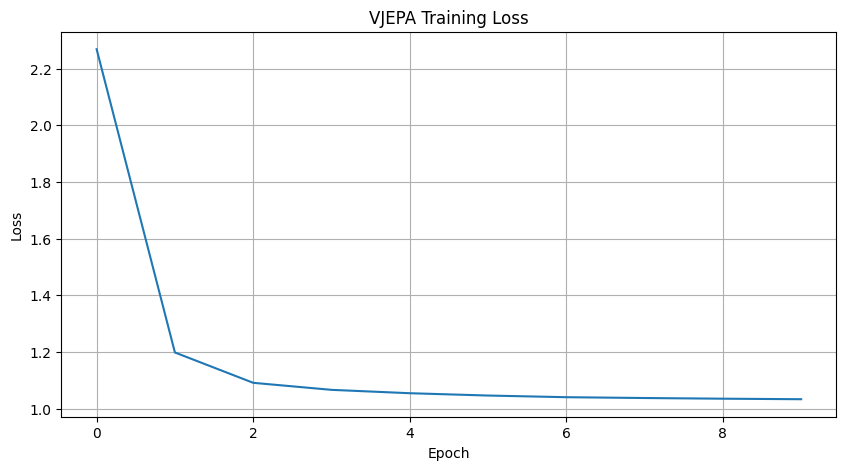

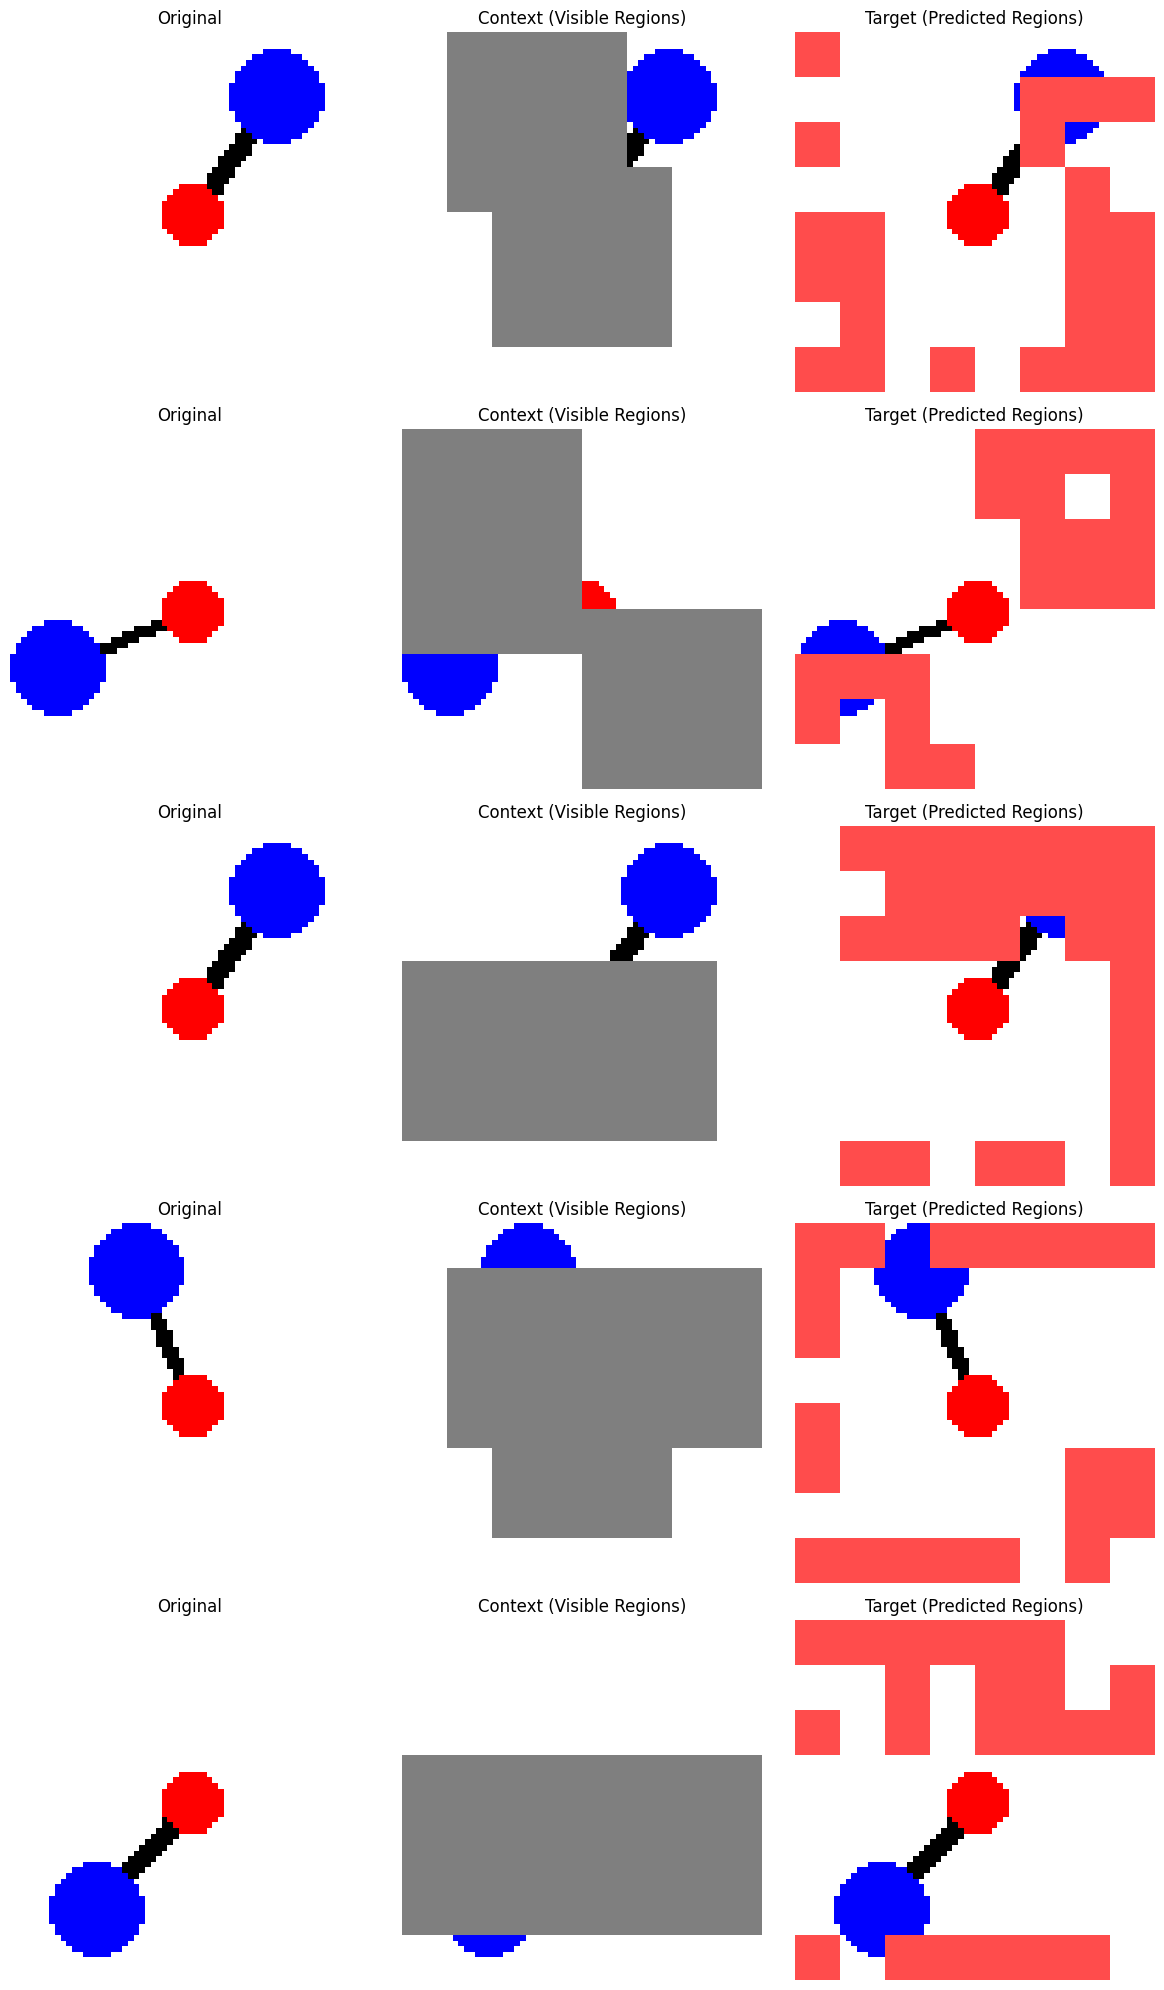

Training completed!


Extracting embeddings:   9%|▉         | 7/79 [00:01<00:12,  5.93it/s]



Latent -> Theta R²: 1.0000, MSE: 0.0001
Latent -> Omega R²: 0.2630, MSE: 9.9627


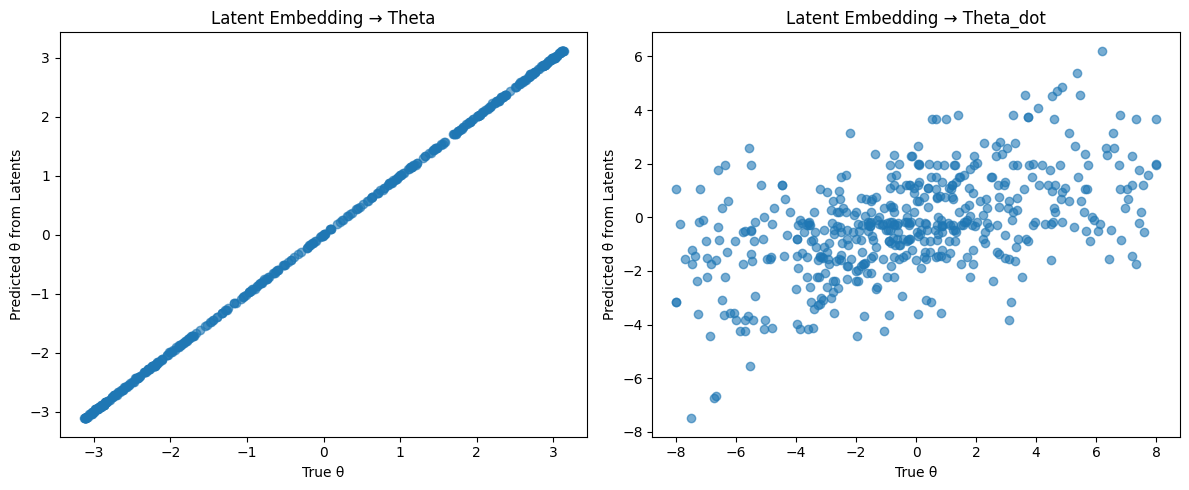

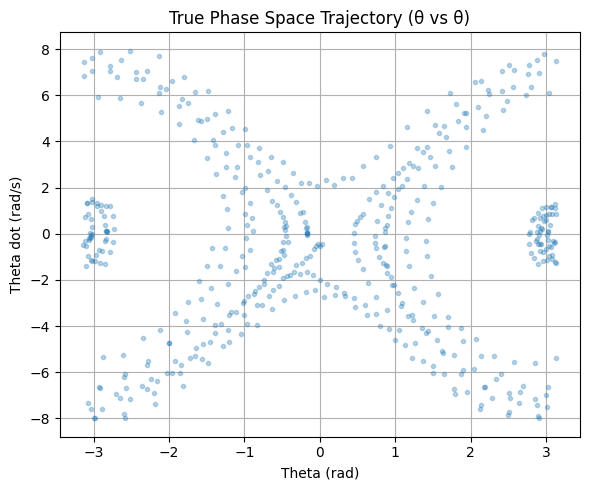

NameError: name 'plot_energy_conservation' is not defined

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================
# 1. Data Collection and Preparation
# ============================

class PendulumDataset(Dataset):
    def __init__(self, num_episodes=100, episode_length=200, img_size=64, transform=None):
        """
        Dataset for pendulum images from OpenAI Gym

        Args:
            num_episodes: Number of episodes to collect
            episode_length: Length of each episode
            img_size: Size to resize images to
            transform: Additional transforms to apply
        """
        self.img_size = img_size
        self.transform = transform

        # Generate synthetic pendulum images
        self.generate_synthetic_pendulum_data(num_episodes, episode_length)

    def generate_synthetic_pendulum_data(self, num_episodes, episode_length):
        """Generate synthetic pendulum data using PIL"""
        print("Generating synthetic pendulum data...")
        self.images = []

        # Create environment to get pendulum dynamics
        env = gym.make('Pendulum-v1')

        # Set up parameters for drawing pendulum
        img_size = self.img_size
        pendulum_length = img_size * 0.4
        center_x, center_y = img_size // 2, img_size // 2

        self.images = []
        self.labels = []

        for episode in tqdm(range(num_episodes)):
            # Reset environment
            obs = env.reset()
            if isinstance(obs, tuple):
                obs = obs[0]  # New API returns (obs, info)

            # Extract theta from observation
            # In Pendulum-v1, obs[0] = cos(theta), obs[1] = sin(theta)
            theta = np.arctan2(obs[1], obs[0])

            for step in range(episode_length):
                # Take random action
                action = env.action_space.sample()

                # Step the environment
                step_result = env.step(action)

                # Handle different Gym API versions
                if len(step_result) == 4:  # Old API
                    obs, reward, done, _ = step_result
                else:  # New API
                    obs, reward, terminated, truncated, _ = step_result
                    done = terminated or truncated

                # Extract theta from observation
                theta = np.arctan2(obs[1], obs[0])
                omega = obs[2]

                # Draw pendulum image
                # Create a blank image
                img = Image.new('RGB', (img_size, img_size), color='white')
                draw = ImageDraw.Draw(img)

                # Calculate pendulum endpoint
                end_x = int(center_x + pendulum_length * np.sin(theta))
                end_y = int(center_y + pendulum_length * np.cos(theta))

                # Draw pendulum rod
                draw.line([(center_x, center_y), (end_x, end_y)], fill='black', width=3)

                # Draw pivot point
                draw.ellipse(
                    [(center_x-5, center_y-5), (center_x+5, center_y+5)],
                    fill='red'
                )

                # Draw bob
                draw.ellipse(
                    [(end_x-8, end_y-8), (end_x+8, end_y+8)],
                    fill='blue'
                )

                # Convert to numpy array
                img_array = np.array(img)

                # Add to dataset
                self.images.append(img_array)
                self.labels.append((theta, omega))

                if done:
                    break

        env.close()
        self.images = np.array(self.images)
        print(f"Dataset created with {len(self.images)} images")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        # Convert to tensor
        img = torch.from_numpy(img).float() / 255.0
        img = img.permute(2, 0, 1)  # Convert to CxHxW format

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(label, dtype=torch.float32)

        return img, label

    def __len__(self):
        return len(self.images)

    # def __getitem__(self, idx):
    #     img = self.images[idx]

    #     # Convert to tensor
    #     img = torch.from_numpy(img).float() / 255.0
    #     img = img.permute(2, 0, 1)  # Convert to CxHxW format

    #     if self.transform:
    #         img = self.transform(img)

    #     return img

# ============================
# 2. VJEPA Architecture
# ============================

class PatchEmbed(nn.Module):
    """
    Image to Patch Embedding
    """
    def __init__(self, img_size=64, patch_size=8, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (B, n_patches, embed_dim)
        return x

class TransformerEncoder(nn.Module):
    """
    Transformer encoder block
    """
    def __init__(self, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            layer = nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=int(embed_dim * mlp_ratio),
                batch_first=True,
                norm_first=True
            )
            self.layers.append(layer)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class MaskingStrategy:
    """
    Handles masked prediction strategies for JEPA/VJEPA
    """
    def __init__(self, num_patches, mask_ratio=0.75, block_size=4):
        self.num_patches = num_patches
        self.mask_ratio = mask_ratio
        self.block_size = block_size

    def random_masking(self, batch_size):
        """Generate random masks for a batch"""
        n_keep = int(self.num_patches * (1 - self.mask_ratio))

        # For each sample, randomly select patches to keep
        noise = torch.rand(batch_size, self.num_patches, device=device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # Determine which patches to keep
        mask = torch.ones([batch_size, self.num_patches], device=device)
        mask[:, :n_keep] = 0
        # Unshuffle to get the mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return mask.bool()  # masked positions are True

    def block_masking(self, batch_size):
        """Generate block-wise masks"""
        grid_size = int(np.sqrt(self.num_patches))

        # Create empty masks
        masks = torch.zeros(batch_size, self.num_patches, device=device)

        for b in range(batch_size):
            # Number of blocks to mask
            n_blocks = int((self.num_patches * self.mask_ratio) / (self.block_size**2))

            # Randomly choose block starting positions
            for _ in range(n_blocks):
                # Choose random top-left corner for block
                h_start = np.random.randint(0, grid_size - self.block_size + 1)
                w_start = np.random.randint(0, grid_size - self.block_size + 1)

                # Mask all patches in this block
                for h in range(h_start, h_start + self.block_size):
                    for w in range(w_start, w_start + self.block_size):
                        patch_idx = h * grid_size + w
                        masks[b, patch_idx] = 1

        return masks.bool()  # masked positions are True

class VJEPA(nn.Module):
    """
    Vision-based Joint Embedding Predictive Architecture
    """
    def __init__(
        self,
        img_size=64,
        patch_size=8,
        in_chans=3,
        embed_dim=768,
        depth=12,
        num_heads=12,
        decoder_embed_dim=512,
        decoder_depth=8,
        decoder_num_heads=16,
        mlp_ratio=4.0,
        prediction_head_dim=384
    ):
        super().__init__()

        # Patch embedding
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim
        )

        # Number of patches
        self.num_patches = self.patch_embed.n_patches

        # Position embeddings
        self.pos_embed = nn.Parameter(
            torch.zeros(1, self.num_patches, embed_dim)
        )

        # Context encoder (f_θ)
        self.context_encoder = TransformerEncoder(
            embed_dim=embed_dim,
            depth=depth,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio
        )

        # Target encoder (g_ϕ)
        self.target_encoder = TransformerEncoder(
            embed_dim=embed_dim,
            depth=depth,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio
        )

        # Predictor network
        self.predictor = nn.Sequential(
            nn.Linear(embed_dim, prediction_head_dim),
            nn.GELU(),
            nn.Linear(prediction_head_dim, embed_dim)
        )

        # Masking strategy
        self.masking = MaskingStrategy(self.num_patches)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        # Initialize position embeddings
        nn.init.normal_(self.pos_embed, std=0.02)

        # Initialize projection layers
        self.apply(self._init_weights_layer)

    def _init_weights_layer(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    # def forward_context(self, imgs, context_mask):
    #     """Process the context (visible) regions"""
    #     # Get patch embeddings
    #     x = self.patch_embed(imgs)

    #     # Add position embeddings
    #     x = x + self.pos_embed

    #     # Get unmasked patches
    #     unmasked_indices = ~context_mask
    #     x_unmasked = x[unmasked_indices].reshape(imgs.shape[0], -1, x.shape[-1])

    #     # Encode context
    #     context_feats = self.context_encoder(x_unmasked)

    #     return context_feats
    def forward_context(self, imgs, context_mask):
      """Process the context (visible) regions"""
      # Get patch embeddings
      x = self.patch_embed(imgs)  # [B, num_patches, embed_dim]

      # Add positional embeddings
      x = x + self.pos_embed  # [B, num_patches, embed_dim]

      B, N, D = x.shape
      unmasked_indices = ~context_mask  # [B, num_patches]

      # Collect unmasked patches per sample
      x_unmasked = []

      for i in range(B):
          patches = x[i][unmasked_indices[i]]  # [num_unmasked_i, D]

          # Pad to the max number of patches in the batch
          num_unmasked = patches.shape[0]
          padded = F.pad(patches, (0, 0, 0, N - num_unmasked))  # [N, D]
          x_unmasked.append(padded)

      x_unmasked = torch.stack(x_unmasked)  # [B, N, D]

      # Optionally, create attention masks if Transformer should ignore padded tokens

      # Encode context
      context_feats = self.context_encoder(x_unmasked)  # [B, N, D]

      return context_feats


    def forward_target(self, imgs, target_mask):
        """Process the target (masked) regions"""
        # Get patch embeddings
        x = self.patch_embed(imgs)  # [B, num_patches, embed_dim]

        # Add positional embeddings
        x = x + self.pos_embed

        B, N, D = x.shape
        masked_indices = target_mask  # [B, num_patches]

        x_masked = []

        for i in range(B):
            patches = x[i][masked_indices[i]]  # [num_masked_i, D]

            # Pad to full length N
            num_masked = patches.shape[0]
            padded = F.pad(patches, (0, 0, 0, N - num_masked))  # [N, D]
            x_masked.append(padded)

        x_masked = torch.stack(x_masked)  # [B, N, D]

        # Encode masked regions (targets)
        target_feats = self.target_encoder(x_masked)

        return target_feats


    def forward(self, imgs):
        """
        Forward pass of VJEPA

        Args:
            imgs: Batch of images [B, C, H, W]

        Returns:
            loss: VJEPA loss value
            pred: Predicted embeddings
            target: Target embeddings
        """
        B = imgs.shape[0]

        # Generate masks for context and target
        context_mask = self.masking.block_masking(B)
        target_mask = self.masking.random_masking(B)

        # Ensure context and target don't overlap
        overlap_mask = context_mask & target_mask
        target_mask = target_mask & ~overlap_mask

        # Forward pass through context encoder
        context_feats = self.forward_context(imgs, context_mask)

        # Forward pass through target encoder
        with torch.no_grad():  # Stop gradient for target encoder
            target_feats = self.forward_target(imgs, target_mask)

        # Generate predictions from context
        pred = self.predictor(context_feats)

        # Compute loss
        loss = F.mse_loss(pred, target_feats)

        return loss, pred, target_feats

# ============================
# 3. Training Function
# ============================

def train_vjepa(model, theta_head, vec_field,
                train_loader, optimizer,
                num_epochs=100, log_interval=10,
                lambda_phys=1e-3, lambda_sup=1e-2):
    """
    Train VJEPA with an additional Hamiltonian physics loss.
    """
    model.train(); theta_head.train(); vec_field.train()
    losses = []

    print("Starting training…")
    for epoch in range(num_epochs):
        epoch_loss = 0.0

        for step, (imgs, labels) in enumerate(
                tqdm(train_loader, unit="batch",
                     desc=f"Epoch {epoch+1}/{num_epochs}")):

            imgs, labels = imgs.to(device), labels.to(device)   # labels = (θ, ω)

            # ─── 1. JEPA reconstruction loss ─────────────────────────
            loss_jepa, _, _ = model(imgs)

            # ─── 2. Latent → (θ̂ , ω̂)  (NO torch.no_grad!) ───────────
            lat = model.patch_embed(imgs) + model.pos_embed     # [B,N,D]
            lat = model.context_encoder(lat)                    # [B,N,D]
            z   = lat.mean(dim=1)                               # [B,D]
            theta_pred, omega_pred = theta_head(z).split(1, dim=1)  # [B,1] each

            # ─── 3. Physics loss  dq/dt ≈ ω_true ────────────────────
            state   = torch.cat([theta_pred, omega_pred], dim=1)      # [B,2]
            dqdt_pred = vec_field.time_derivative(state)[:, :1]       # (B,1)
            omega_true = labels[:, 1:2]                                # ω_true
            phys_loss  = F.mse_loss(dqdt_pred, omega_true)

            # optional direct θ supervision (helps the linear head converge)
            theta_true = labels[:, 0:1]
            sup_loss   = F.mse_loss(theta_pred, theta_true)

            # ─── 4. Total objective ─────────────────────────────────
            loss = loss_jepa + lambda_phys * phys_loss + lambda_sup * sup_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if step % log_interval == 0:
                tqdm.write(f"  step {step:04d}  "
                           f"jepa {loss_jepa.item():.4f}  "
                           f"phys {phys_loss.item():.4f}")

        avg = epoch_loss / len(train_loader)
        losses.append(avg)
        print(f"Epoch {epoch+1} complete — avg loss {avg:.4f}")

    return losses

# ============================
# 4. Visualization Functions
# ============================
def visualize_reconstructions(model, dataset, num_samples=5):
    """Visualize original images and their reconstructions"""
    model.eval()

    # Create a dataloader with batch size equal to num_samples
    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
    imgs, _ = next(iter(loader))  # <-- FIXED: unpack the tuple
    imgs = imgs.to(device)

    # Get reconstructions
    with torch.no_grad():
        # Generate masks
        B = imgs.shape[0]
        context_mask = model.masking.block_masking(B)
        target_mask = model.masking.random_masking(B)

        # Ensure no overlap
        overlap_mask = context_mask & target_mask
        target_mask = target_mask & ~overlap_mask

        # Get features
        context_feats = model.forward_context(imgs, context_mask)
        pred = model.predictor(context_feats)

    # Visualize the results
    plt.figure(figsize=(12, 4 * num_samples))

    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 3, i * 3 + 1)
        img = imgs[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title("Original")
        plt.axis('off')

        # Masked image (context)
        plt.subplot(num_samples, 3, i * 3 + 2)
        masked_img = imgs[i].clone().cpu()

        grid_size = int(np.sqrt(model.num_patches))
        mask_reshaped = context_mask[i].reshape(1, 1, grid_size, grid_size).float()
        mask_upsampled = F.interpolate(
            mask_reshaped,
            size=(imgs.shape[2], imgs.shape[3]),
            mode='nearest'
        ).squeeze()

        for c in range(3):
            masked_img[c][mask_upsampled.bool()] = 0.5  # Gray out masked areas

        plt.imshow(masked_img.permute(1, 2, 0).numpy())
        plt.title("Context (Visible Regions)")
        plt.axis('off')

        # Target image (highlight predicted regions)
        plt.subplot(num_samples, 3, i * 3 + 3)
        target_img = imgs[i].clone().cpu()

        target_mask_reshaped = target_mask[i].reshape(1, 1, grid_size, grid_size).float()
        target_mask_upsampled = F.interpolate(
            target_mask_reshaped,
            size=(imgs.shape[2], imgs.shape[3]),
            mode='nearest'
        ).squeeze()

        for c in range(3):
            if c == 0:  # Red channel
                target_img[c][target_mask_upsampled.bool()] = 1.0
            else:
                target_img[c][target_mask_upsampled.bool()] = 0.3

        plt.imshow(target_img.permute(1, 2, 0).numpy())
        plt.title("Target (Predicted Regions)")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('vjepa_reconstructions.png')
    plt.show()


def plot_training_loss(losses):
    """Plot training loss over epochs"""
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('VJEPA Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig('vjepa_training_loss.png')
    plt.show()

# ============================
# 5. Main Execution
# ============================

def main():
    # Configuration
    batch_size = 32
    img_size = 64
    patch_size = 8
    embed_dim = 384  # Smaller for faster training
    depth = 6  # Smaller depth for faster training
    num_heads = 6
    prediction_head_dim = 192
    learning_rate = 1e-4
    num_epochs = 10

    # Create dataset
    dataset = PendulumDataset(num_episodes=50, episode_length=100, img_size=img_size)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)  # Set num_workers=0 for compatibility

    # Create model
    model = VJEPA(
        img_size=img_size,
        patch_size=patch_size,
        in_chans=3,
        embed_dim=embed_dim,
        depth=depth,
        num_heads=num_heads,
        decoder_embed_dim=embed_dim // 2,
        decoder_depth=4,
        decoder_num_heads=num_heads,
        mlp_ratio=4.0,
        prediction_head_dim=prediction_head_dim
    ).to(device)
    
    ######################################################################
    # (B)  immediately after you create the VJEPA model,                    │
    #      create a SINGLE linear mapping from latent → (θ̂ , ω̂).          │
    #      this will be trained jointly with V-JEPA and the HNN.            │
    ######################################################################
    latent_dim  = embed_dim              # = 384 in your config
    theta_head  = torch.nn.Linear(latent_dim, 2, bias=True).to(device)
    
    ######################################################################
    # (C)  instantiate an HNN ONCE  (again, right after model creation)
    ######################################################################
    vec_field = HNN(
        input_dim            = 2,            # (q, p)  where q = θ , p = ω
        differentiable_model = MLP(2, 256, 2),
        field_type           = 'solenoidal', # canonical Hamiltonian flow
        baseline             = False
    ).to(device)

    optimizer = optim.AdamW(
    list(model.parameters()) +
    list(theta_head.parameters()) +
    list(vec_field.parameters()),
    lr=learning_rate)

    # ------- training --------------------------------------------
    losses = train_vjepa(model, theta_head, vec_field,
                     train_loader, optimizer,
                     num_epochs=num_epochs)

    # Plot training loss
    plot_training_loss(losses)

    # Visualize reconstructions
    visualize_reconstructions(model, dataset)

    # Save final model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, "vjepa_pendulum_final.pt")

    print("Training completed!")

    analyze_vjepa_latent_phase_relation(model,dataset )
    plot_true_phase_space(dataset)
    # plot_energy_conservation(dataset)

if __name__ == "__main__":
    main()

In [2]:
# ---------------------------------------------------------------
# Torch re-implementation of Miles Cranmer’s LNN (JAX → PyTorch)
# ---------------------------------------------------------------
class LNN(nn.Module):
    """
    Minimal PyTorch Lagrangian Neural Network.
    Learns a scalar L(q, v); returns Euler–Lagrange residual loss.
    """
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, qv):                    # (B, 2d) → scalar L
        return self.net(qv)

    def lagrangian_residual(self, q, v, dt=1.0):
        """
        q, v : (B, T, d)  – batch of trajectories (T≥2).
        Returns MSE of Euler–Lagrange residuals over B×(T-1) steps.
        """
        B, T, d = q.shape
        z   = torch.cat([q, v], dim=-1).reshape(B*T, -1).requires_grad_(True)
        L   = self.forward(z).sum()                    # scalar
        dLd  = torch.autograd.grad(L, z, create_graph=True)[0]
        dL_dq, dL_dv = dLd.split(d, dim=-1)
        dL_dq = dL_dq.reshape(B, T, d)
        dL_dv = dL_dv.reshape(B, T, d)

        # finite-difference time derivative of ∂L/∂v
        ddt_dLdv = (dL_dv[:,1:] - dL_dv[:,:-1]) / dt   # (B,T-1,d)
        res      = ddt_dLdv - dL_dq[:,:-1]             # (B,T-1,d)
        return (res**2).mean()

Using device: cpu
Generating synthetic pendulum data...


100%|██████████| 50/50 [00:00<00:00, 161.01it/s]


Dataset created with 5000 images
Starting training…


Epoch 1/10:   1%|          | 1/157 [00:01<03:06,  1.20s/batch]

step 0000 | jepa 6.6755 | phys nan


Epoch 1/10:   7%|▋         | 11/157 [00:11<02:24,  1.01batch/s]

step 0010 | jepa 4.0677 | phys nan


Epoch 1/10:  13%|█▎        | 21/157 [00:21<02:16,  1.00s/batch]

step 0020 | jepa 3.6807 | phys nan


Epoch 1/10:  20%|█▉        | 31/157 [00:31<02:04,  1.01batch/s]

step 0030 | jepa 3.2795 | phys nan


Epoch 1/10:  26%|██▌       | 41/157 [00:41<01:52,  1.03batch/s]

step 0040 | jepa 2.8731 | phys nan


Epoch 1/10:  32%|███▏      | 51/157 [00:51<01:44,  1.02batch/s]

step 0050 | jepa 2.5031 | phys nan


Epoch 1/10:  39%|███▉      | 61/157 [01:02<01:44,  1.09s/batch]

step 0060 | jepa 2.1642 | phys nan


Epoch 1/10:  45%|████▌     | 71/157 [01:12<01:31,  1.06s/batch]

step 0070 | jepa 1.8836 | phys nan


Epoch 1/10:  52%|█████▏    | 81/157 [01:23<01:22,  1.08s/batch]

step 0080 | jepa 1.6832 | phys nan


Epoch 1/10:  58%|█████▊    | 91/157 [01:34<01:12,  1.10s/batch]

step 0090 | jepa 1.5370 | phys nan


Epoch 1/10:  64%|██████▍   | 101/157 [01:45<01:00,  1.08s/batch]

step 0100 | jepa 1.4383 | phys nan


Epoch 1/10:  71%|███████   | 111/157 [01:56<00:49,  1.08s/batch]

step 0110 | jepa 1.3806 | phys nan


Epoch 1/10:  77%|███████▋  | 121/157 [02:07<00:40,  1.12s/batch]

step 0120 | jepa 1.3278 | phys nan


Epoch 1/10:  83%|████████▎ | 131/157 [02:18<00:28,  1.09s/batch]

step 0130 | jepa 1.2903 | phys nan


Epoch 1/10:  90%|████████▉ | 141/157 [02:29<00:17,  1.08s/batch]

step 0140 | jepa 1.2744 | phys nan


Epoch 1/10:  96%|█████████▌| 151/157 [02:40<00:06,  1.09s/batch]

step 0150 | jepa 1.2609 | phys nan


Epoch 1/10: 100%|██████████| 157/157 [02:46<00:00,  1.06s/batch]


Epoch 1 complete — avg loss nan


Epoch 2/10:   1%|          | 1/157 [00:01<03:03,  1.18s/batch]

step 0000 | jepa 1.2437 | phys nan


Epoch 2/10:   7%|▋         | 11/157 [00:12<02:38,  1.08s/batch]

step 0010 | jepa 1.2463 | phys nan


Epoch 2/10:  13%|█▎        | 21/157 [00:23<02:32,  1.12s/batch]

step 0020 | jepa 1.2275 | phys nan


Epoch 2/10:  20%|█▉        | 31/157 [00:34<02:16,  1.09s/batch]

step 0030 | jepa 1.2209 | phys nan


Epoch 2/10:  26%|██▌       | 41/157 [00:45<02:08,  1.11s/batch]

step 0040 | jepa 1.2074 | phys nan


Epoch 2/10:  32%|███▏      | 51/157 [00:56<01:53,  1.07s/batch]

step 0050 | jepa 1.2125 | phys nan


Epoch 2/10:  39%|███▉      | 61/157 [01:07<01:43,  1.08s/batch]

step 0060 | jepa 1.1879 | phys nan


Epoch 2/10:  45%|████▌     | 71/157 [01:18<01:36,  1.12s/batch]

step 0070 | jepa 1.1869 | phys nan


Epoch 2/10:  52%|█████▏    | 81/157 [01:29<01:22,  1.08s/batch]

step 0080 | jepa 1.1711 | phys nan


Epoch 2/10:  58%|█████▊    | 91/157 [01:40<01:10,  1.07s/batch]

step 0090 | jepa 1.1647 | phys nan


Epoch 2/10:  64%|██████▍   | 101/157 [01:51<01:01,  1.09s/batch]

step 0100 | jepa 1.1465 | phys nan


Epoch 2/10:  71%|███████   | 111/157 [02:01<00:49,  1.08s/batch]

step 0110 | jepa 1.1531 | phys nan


Epoch 2/10:  77%|███████▋  | 121/157 [02:13<00:40,  1.13s/batch]

step 0120 | jepa 1.1209 | phys nan


Epoch 2/10:  83%|████████▎ | 131/157 [02:24<00:31,  1.23s/batch]

step 0130 | jepa 1.1247 | phys nan


Epoch 2/10:  90%|████████▉ | 141/157 [02:35<00:17,  1.10s/batch]

step 0140 | jepa 1.1098 | phys nan


Epoch 2/10:  96%|█████████▌| 151/157 [02:47<00:07,  1.21s/batch]

step 0150 | jepa 1.1035 | phys nan


Epoch 2/10: 100%|██████████| 157/157 [02:53<00:00,  1.11s/batch]


Epoch 2 complete — avg loss nan


Epoch 3/10:   1%|          | 1/157 [00:01<03:29,  1.34s/batch]

step 0000 | jepa 1.1131 | phys nan


Epoch 3/10:   7%|▋         | 11/157 [00:14<02:54,  1.20s/batch]

step 0010 | jepa 1.0958 | phys nan


Epoch 3/10:  13%|█▎        | 21/157 [00:26<03:00,  1.33s/batch]

step 0020 | jepa 1.0855 | phys nan


Epoch 3/10:  20%|█▉        | 31/157 [00:38<02:21,  1.13s/batch]

step 0030 | jepa 1.0910 | phys nan


Epoch 3/10:  26%|██▌       | 41/157 [00:49<02:06,  1.09s/batch]

step 0040 | jepa 1.0848 | phys nan


Epoch 3/10:  32%|███▏      | 51/157 [01:00<01:56,  1.10s/batch]

step 0050 | jepa 1.0922 | phys nan


Epoch 3/10:  39%|███▉      | 61/157 [01:10<01:43,  1.08s/batch]

step 0060 | jepa 1.0802 | phys nan


Epoch 3/10:  45%|████▌     | 71/157 [01:21<01:32,  1.08s/batch]

step 0070 | jepa 1.0642 | phys nan


Epoch 3/10:  52%|█████▏    | 81/157 [01:32<01:23,  1.09s/batch]

step 0080 | jepa 1.0747 | phys nan


Epoch 3/10:  58%|█████▊    | 91/157 [01:43<01:10,  1.07s/batch]

step 0090 | jepa 1.0752 | phys nan


Epoch 3/10:  64%|██████▍   | 101/157 [01:54<01:00,  1.08s/batch]

step 0100 | jepa 1.0747 | phys nan


Epoch 3/10:  71%|███████   | 111/157 [02:05<00:50,  1.09s/batch]

step 0110 | jepa 1.0603 | phys nan


Epoch 3/10:  77%|███████▋  | 121/157 [02:15<00:39,  1.08s/batch]

step 0120 | jepa 1.0681 | phys nan


Epoch 3/10:  83%|████████▎ | 131/157 [02:26<00:28,  1.08s/batch]

step 0130 | jepa 1.0721 | phys nan


Epoch 3/10:  90%|████████▉ | 141/157 [02:37<00:17,  1.08s/batch]

step 0140 | jepa 1.0588 | phys nan


Epoch 3/10:  96%|█████████▌| 151/157 [02:48<00:06,  1.07s/batch]

step 0150 | jepa 1.0537 | phys nan


Epoch 3/10: 100%|██████████| 157/157 [02:54<00:00,  1.11s/batch]


Epoch 3 complete — avg loss nan


Epoch 4/10:   1%|          | 1/157 [00:01<02:56,  1.13s/batch]

step 0000 | jepa 1.0663 | phys nan


Epoch 4/10:   7%|▋         | 11/157 [00:11<02:37,  1.08s/batch]

step 0010 | jepa 1.0580 | phys nan


Epoch 4/10:  13%|█▎        | 21/157 [00:22<02:29,  1.10s/batch]

step 0020 | jepa 1.0541 | phys nan


Epoch 4/10:  20%|█▉        | 31/157 [00:33<02:19,  1.11s/batch]

step 0030 | jepa 1.0487 | phys nan


Epoch 4/10:  26%|██▌       | 41/157 [00:45<02:08,  1.10s/batch]

step 0040 | jepa 1.0640 | phys nan


Epoch 4/10:  32%|███▏      | 51/157 [00:55<01:55,  1.09s/batch]

step 0050 | jepa 1.0458 | phys nan


Epoch 4/10:  39%|███▉      | 61/157 [01:06<01:43,  1.08s/batch]

step 0060 | jepa 1.0559 | phys nan


Epoch 4/10:  45%|████▌     | 71/157 [01:17<01:33,  1.09s/batch]

step 0070 | jepa 1.0449 | phys nan


Epoch 4/10:  52%|█████▏    | 81/157 [01:28<01:23,  1.09s/batch]

step 0080 | jepa 1.0466 | phys nan


Epoch 4/10:  58%|█████▊    | 91/157 [01:39<01:11,  1.09s/batch]

step 0090 | jepa 1.0509 | phys nan


Epoch 4/10:  64%|██████▍   | 101/157 [01:50<00:59,  1.07s/batch]

step 0100 | jepa 1.0544 | phys nan


Epoch 4/10:  71%|███████   | 111/157 [02:01<00:49,  1.07s/batch]

step 0110 | jepa 1.0547 | phys nan


Epoch 4/10:  77%|███████▋  | 121/157 [02:11<00:38,  1.07s/batch]

step 0120 | jepa 1.0584 | phys nan


Epoch 4/10:  83%|████████▎ | 131/157 [02:22<00:28,  1.10s/batch]

step 0130 | jepa 1.0491 | phys nan


Epoch 4/10:  90%|████████▉ | 141/157 [02:33<00:17,  1.09s/batch]

step 0140 | jepa 1.0422 | phys nan


Epoch 4/10:  96%|█████████▌| 151/157 [02:45<00:06,  1.13s/batch]

step 0150 | jepa 1.0561 | phys nan


Epoch 4/10: 100%|██████████| 157/157 [02:51<00:00,  1.09s/batch]


Epoch 4 complete — avg loss nan


Epoch 5/10:   1%|          | 1/157 [00:01<03:10,  1.22s/batch]

step 0000 | jepa 1.0366 | phys nan


Epoch 5/10:   7%|▋         | 11/157 [00:12<02:40,  1.10s/batch]

step 0010 | jepa 1.0452 | phys nan


Epoch 5/10:  13%|█▎        | 21/157 [00:23<02:31,  1.12s/batch]

step 0020 | jepa 1.0458 | phys nan


Epoch 5/10:  20%|█▉        | 31/157 [00:34<02:20,  1.12s/batch]

step 0030 | jepa 1.0568 | phys nan


Epoch 5/10:  26%|██▌       | 41/157 [00:45<02:07,  1.10s/batch]

step 0040 | jepa 1.0440 | phys nan


Epoch 5/10:  32%|███▏      | 51/157 [00:56<01:56,  1.10s/batch]

step 0050 | jepa 1.0339 | phys nan


Epoch 5/10:  39%|███▉      | 61/157 [01:07<01:43,  1.08s/batch]

step 0060 | jepa 1.0430 | phys nan


Epoch 5/10:  45%|████▌     | 71/157 [01:18<01:33,  1.08s/batch]

step 0070 | jepa 1.0348 | phys nan


Epoch 5/10:  52%|█████▏    | 81/157 [01:28<01:21,  1.07s/batch]

step 0080 | jepa 1.0348 | phys nan


Epoch 5/10:  58%|█████▊    | 91/157 [01:39<01:10,  1.06s/batch]

step 0090 | jepa 1.0399 | phys nan


Epoch 5/10:  64%|██████▍   | 101/157 [01:51<01:11,  1.28s/batch]

step 0100 | jepa 1.0271 | phys nan


Epoch 5/10:  71%|███████   | 111/157 [02:03<00:52,  1.15s/batch]

step 0110 | jepa 1.0432 | phys nan


Epoch 5/10:  77%|███████▋  | 121/157 [02:14<00:39,  1.10s/batch]

step 0120 | jepa 1.0320 | phys nan


Epoch 5/10:  83%|████████▎ | 131/157 [02:26<00:29,  1.14s/batch]

step 0130 | jepa 1.0397 | phys nan


Epoch 5/10:  90%|████████▉ | 141/157 [02:37<00:17,  1.09s/batch]

step 0140 | jepa 1.0414 | phys nan


Epoch 5/10:  96%|█████████▌| 151/157 [02:48<00:06,  1.09s/batch]

step 0150 | jepa 1.0439 | phys nan


Epoch 5/10: 100%|██████████| 157/157 [02:53<00:00,  1.11s/batch]


Epoch 5 complete — avg loss nan


Epoch 6/10:   1%|          | 1/157 [00:01<03:03,  1.18s/batch]

step 0000 | jepa 1.0411 | phys nan


Epoch 6/10:   7%|▋         | 11/157 [00:12<02:37,  1.08s/batch]

step 0010 | jepa 1.0404 | phys nan


Epoch 6/10:  13%|█▎        | 21/157 [00:22<02:26,  1.08s/batch]

step 0020 | jepa 1.0392 | phys nan


Epoch 6/10:  20%|█▉        | 31/157 [00:33<02:16,  1.08s/batch]

step 0030 | jepa 1.0299 | phys nan


Epoch 6/10:  26%|██▌       | 41/157 [00:44<02:05,  1.09s/batch]

step 0040 | jepa 1.0303 | phys nan


Epoch 6/10:  32%|███▏      | 51/157 [00:55<01:54,  1.08s/batch]

step 0050 | jepa 1.0316 | phys nan


Epoch 6/10:  39%|███▉      | 61/157 [01:06<01:44,  1.09s/batch]

step 0060 | jepa 1.0395 | phys nan


Epoch 6/10:  45%|████▌     | 71/157 [01:18<01:36,  1.12s/batch]

step 0070 | jepa 1.0308 | phys nan


Epoch 6/10:  52%|█████▏    | 81/157 [01:29<01:24,  1.11s/batch]

step 0080 | jepa 1.0262 | phys nan


Epoch 6/10:  58%|█████▊    | 91/157 [01:40<01:13,  1.11s/batch]

step 0090 | jepa 1.0338 | phys nan


Epoch 6/10:  64%|██████▍   | 101/157 [01:51<01:03,  1.13s/batch]

step 0100 | jepa 1.0381 | phys nan


Epoch 6/10:  71%|███████   | 111/157 [02:02<00:49,  1.08s/batch]

step 0110 | jepa 1.0335 | phys nan


Epoch 6/10:  77%|███████▋  | 121/157 [02:13<00:38,  1.06s/batch]

step 0120 | jepa 1.0301 | phys nan


Epoch 6/10:  83%|████████▎ | 131/157 [02:24<00:30,  1.18s/batch]

step 0130 | jepa 1.0321 | phys nan


Epoch 6/10:  90%|████████▉ | 141/157 [02:36<00:17,  1.11s/batch]

step 0140 | jepa 1.0324 | phys nan


Epoch 6/10:  96%|█████████▌| 151/157 [02:46<00:06,  1.07s/batch]

step 0150 | jepa 1.0294 | phys nan


Epoch 6/10: 100%|██████████| 157/157 [02:52<00:00,  1.10s/batch]


Epoch 6 complete — avg loss nan


Epoch 7/10:   1%|          | 1/157 [00:01<02:49,  1.09s/batch]

step 0000 | jepa 1.0375 | phys nan


Epoch 7/10:   7%|▋         | 11/157 [00:11<02:38,  1.08s/batch]

step 0010 | jepa 1.0332 | phys nan


Epoch 7/10:  13%|█▎        | 21/157 [00:22<02:25,  1.07s/batch]

step 0020 | jepa 1.0345 | phys nan


Epoch 7/10:  20%|█▉        | 31/157 [00:33<02:17,  1.09s/batch]

step 0030 | jepa 1.0230 | phys nan


Epoch 7/10:  26%|██▌       | 41/157 [00:44<02:05,  1.08s/batch]

step 0040 | jepa 1.0247 | phys nan


Epoch 7/10:  32%|███▏      | 51/157 [00:55<01:59,  1.13s/batch]

step 0050 | jepa 1.0262 | phys nan


Epoch 7/10:  39%|███▉      | 61/157 [01:06<01:44,  1.09s/batch]

step 0060 | jepa 1.0184 | phys nan


Epoch 7/10:  45%|████▌     | 71/157 [01:17<01:33,  1.09s/batch]

step 0070 | jepa 1.0181 | phys nan


Epoch 7/10:  52%|█████▏    | 81/157 [01:28<01:23,  1.10s/batch]

step 0080 | jepa 1.0256 | phys nan


Epoch 7/10:  58%|█████▊    | 91/157 [01:39<01:12,  1.09s/batch]

step 0090 | jepa 1.0300 | phys nan


Epoch 7/10:  64%|██████▍   | 101/157 [01:50<01:00,  1.08s/batch]

step 0100 | jepa 1.0204 | phys nan


Epoch 7/10:  71%|███████   | 111/157 [02:00<00:49,  1.09s/batch]

step 0110 | jepa 1.0325 | phys nan


Epoch 7/10:  77%|███████▋  | 121/157 [02:11<00:38,  1.08s/batch]

step 0120 | jepa 1.0331 | phys nan


Epoch 7/10:  83%|████████▎ | 131/157 [02:22<00:28,  1.09s/batch]

step 0130 | jepa 1.0270 | phys nan


Epoch 7/10:  90%|████████▉ | 141/157 [02:33<00:17,  1.09s/batch]

step 0140 | jepa 1.0240 | phys nan


Epoch 7/10:  96%|█████████▌| 151/157 [02:44<00:06,  1.08s/batch]

step 0150 | jepa 1.0303 | phys nan


Epoch 7/10: 100%|██████████| 157/157 [02:50<00:00,  1.08s/batch]


Epoch 7 complete — avg loss nan


Epoch 8/10:   1%|          | 1/157 [00:01<02:57,  1.14s/batch]

step 0000 | jepa 1.0197 | phys nan


Epoch 8/10:   7%|▋         | 11/157 [00:12<02:37,  1.08s/batch]

step 0010 | jepa 1.0215 | phys nan


Epoch 8/10:  13%|█▎        | 21/157 [00:22<02:27,  1.09s/batch]

step 0020 | jepa 1.0231 | phys nan


Epoch 8/10:  20%|█▉        | 31/157 [00:33<02:15,  1.07s/batch]

step 0030 | jepa 1.0252 | phys nan


Epoch 8/10:  26%|██▌       | 41/157 [00:44<02:06,  1.09s/batch]

step 0040 | jepa 1.0254 | phys nan


Epoch 8/10:  32%|███▏      | 51/157 [00:55<01:54,  1.08s/batch]

step 0050 | jepa 1.0285 | phys nan


Epoch 8/10:  39%|███▉      | 61/157 [01:06<01:44,  1.09s/batch]

step 0060 | jepa 1.0169 | phys nan


Epoch 8/10:  45%|████▌     | 71/157 [01:17<01:32,  1.08s/batch]

step 0070 | jepa 1.0278 | phys nan


Epoch 8/10:  52%|█████▏    | 81/157 [01:28<01:24,  1.11s/batch]

step 0080 | jepa 1.0227 | phys nan


Epoch 8/10:  58%|█████▊    | 91/157 [01:39<01:12,  1.10s/batch]

step 0090 | jepa 1.0214 | phys nan


Epoch 8/10:  64%|██████▍   | 101/157 [01:50<01:02,  1.11s/batch]

step 0100 | jepa 1.0233 | phys nan


Epoch 8/10:  71%|███████   | 111/157 [02:00<00:49,  1.08s/batch]

step 0110 | jepa 1.0264 | phys nan


Epoch 8/10:  77%|███████▋  | 121/157 [02:11<00:38,  1.07s/batch]

step 0120 | jepa 1.0185 | phys nan


Epoch 8/10:  83%|████████▎ | 131/157 [02:22<00:28,  1.08s/batch]

step 0130 | jepa 1.0231 | phys nan


Epoch 8/10:  90%|████████▉ | 141/157 [02:33<00:17,  1.08s/batch]

step 0140 | jepa 1.0269 | phys nan


Epoch 8/10:  96%|█████████▌| 151/157 [02:44<00:06,  1.08s/batch]

step 0150 | jepa 1.0223 | phys nan


Epoch 8/10: 100%|██████████| 157/157 [02:49<00:00,  1.08s/batch]


Epoch 8 complete — avg loss nan


Epoch 9/10:   1%|          | 1/157 [00:01<03:04,  1.18s/batch]

step 0000 | jepa 1.0229 | phys nan


Epoch 9/10:   7%|▋         | 11/157 [00:12<02:39,  1.09s/batch]

step 0010 | jepa 1.0231 | phys nan


Epoch 9/10:  13%|█▎        | 21/157 [00:23<02:28,  1.09s/batch]

step 0020 | jepa 1.0168 | phys nan


Epoch 9/10:  20%|█▉        | 31/157 [00:34<02:16,  1.08s/batch]

step 0030 | jepa 1.0214 | phys nan


Epoch 9/10:  26%|██▌       | 41/157 [00:45<02:07,  1.10s/batch]

step 0040 | jepa 1.0287 | phys nan


Epoch 9/10:  32%|███▏      | 51/157 [00:56<01:54,  1.08s/batch]

step 0050 | jepa 1.0182 | phys nan


Epoch 9/10:  39%|███▉      | 61/157 [01:06<01:45,  1.09s/batch]

step 0060 | jepa 1.0255 | phys nan


Epoch 9/10:  45%|████▌     | 71/157 [01:18<01:35,  1.11s/batch]

step 0070 | jepa 1.0209 | phys nan


Epoch 9/10:  52%|█████▏    | 81/157 [01:28<01:21,  1.08s/batch]

step 0080 | jepa 1.0220 | phys nan


Epoch 9/10:  58%|█████▊    | 91/157 [01:39<01:12,  1.09s/batch]

step 0090 | jepa 1.0245 | phys nan


Epoch 9/10:  64%|██████▍   | 101/157 [01:50<01:00,  1.08s/batch]

step 0100 | jepa 1.0182 | phys nan


Epoch 9/10:  71%|███████   | 111/157 [02:01<00:50,  1.09s/batch]

step 0110 | jepa 1.0261 | phys nan


Epoch 9/10:  77%|███████▋  | 121/157 [02:12<00:39,  1.09s/batch]

step 0120 | jepa 1.0218 | phys nan


Epoch 9/10:  83%|████████▎ | 131/157 [02:23<00:28,  1.08s/batch]

step 0130 | jepa 1.0268 | phys nan


Epoch 9/10:  90%|████████▉ | 141/157 [02:33<00:17,  1.07s/batch]

step 0140 | jepa 1.0181 | phys nan


Epoch 9/10:  96%|█████████▌| 151/157 [02:46<00:07,  1.21s/batch]

step 0150 | jepa 1.0141 | phys nan


Epoch 9/10: 100%|██████████| 157/157 [02:52<00:00,  1.10s/batch]


Epoch 9 complete — avg loss nan


Epoch 10/10:   1%|          | 1/157 [00:01<03:04,  1.18s/batch]

step 0000 | jepa 1.0228 | phys nan


Epoch 10/10:   7%|▋         | 11/157 [00:12<02:46,  1.14s/batch]

step 0010 | jepa 1.0146 | phys nan


Epoch 10/10:  13%|█▎        | 21/157 [00:23<02:28,  1.09s/batch]

step 0020 | jepa 1.0324 | phys nan


Epoch 10/10:  20%|█▉        | 31/157 [00:34<02:13,  1.06s/batch]

step 0030 | jepa 1.0228 | phys nan


Epoch 10/10:  26%|██▌       | 41/157 [00:44<02:02,  1.06s/batch]

step 0040 | jepa 1.0132 | phys nan


Epoch 10/10:  32%|███▏      | 51/157 [00:55<01:52,  1.06s/batch]

step 0050 | jepa 1.0229 | phys nan


Epoch 10/10:  39%|███▉      | 61/157 [01:05<01:40,  1.05s/batch]

step 0060 | jepa 1.0190 | phys nan


Epoch 10/10:  45%|████▌     | 71/157 [01:16<01:33,  1.09s/batch]

step 0070 | jepa 1.0153 | phys nan


Epoch 10/10:  52%|█████▏    | 81/157 [01:27<01:21,  1.07s/batch]

step 0080 | jepa 1.0136 | phys nan


Epoch 10/10:  58%|█████▊    | 91/157 [01:37<01:09,  1.06s/batch]

step 0090 | jepa 1.0209 | phys nan


Epoch 10/10:  64%|██████▍   | 101/157 [01:48<00:58,  1.05s/batch]

step 0100 | jepa 1.0172 | phys nan


Epoch 10/10:  71%|███████   | 111/157 [01:58<00:47,  1.04s/batch]

step 0110 | jepa 1.0230 | phys nan


Epoch 10/10:  77%|███████▋  | 121/157 [02:09<00:38,  1.06s/batch]

step 0120 | jepa 1.0219 | phys nan


Epoch 10/10:  83%|████████▎ | 131/157 [02:20<00:27,  1.05s/batch]

step 0130 | jepa 1.0180 | phys nan


Epoch 10/10:  90%|████████▉ | 141/157 [02:30<00:17,  1.07s/batch]

step 0140 | jepa 1.0135 | phys nan


Epoch 10/10:  96%|█████████▌| 151/157 [02:42<00:06,  1.12s/batch]

step 0150 | jepa 1.0230 | phys nan


Epoch 10/10: 100%|██████████| 157/157 [02:48<00:00,  1.07s/batch]


Epoch 10 complete — avg loss nan


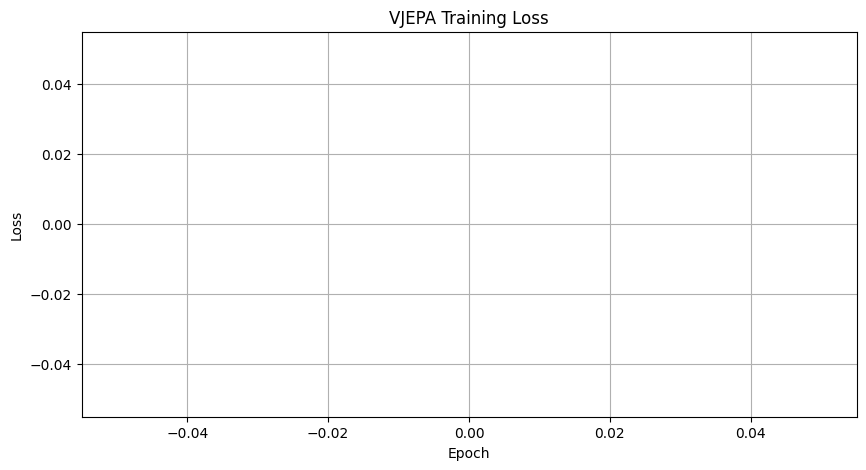

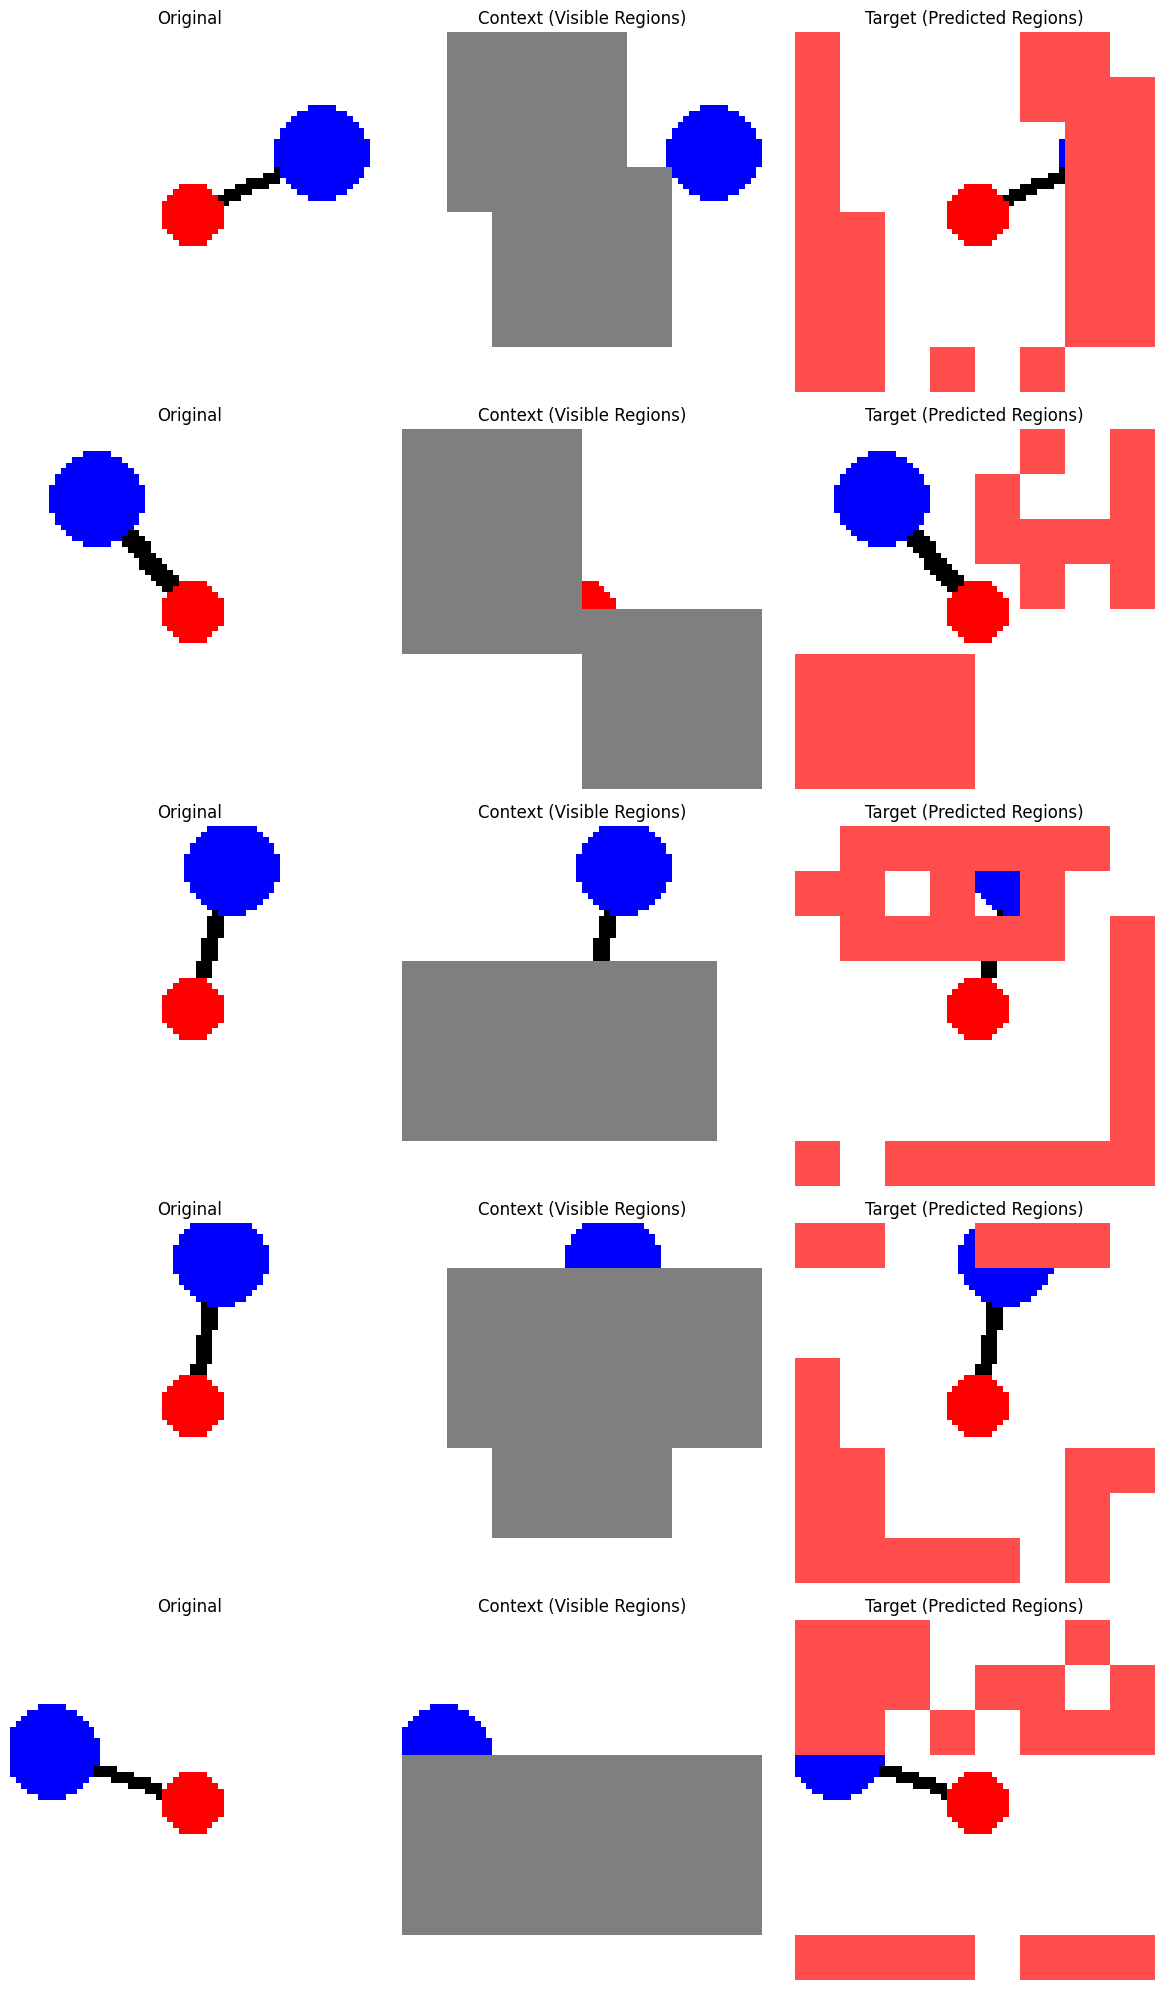

Training completed!


Extracting embeddings:   9%|▉         | 7/79 [00:01<00:13,  5.41it/s]



Latent -> Theta R²: 1.0000, MSE: 0.0001
Latent -> Omega R²: 0.2076, MSE: 10.0964


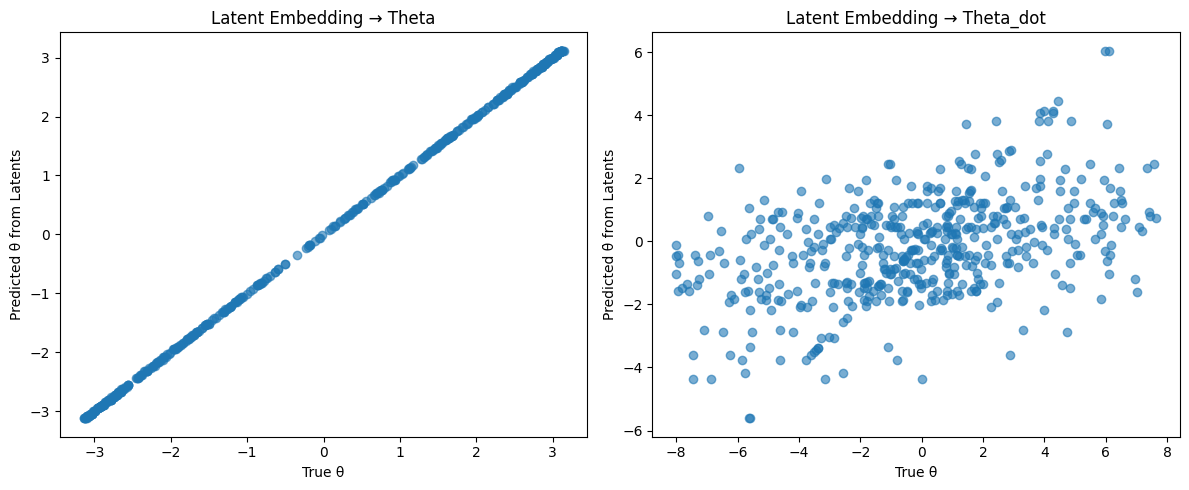

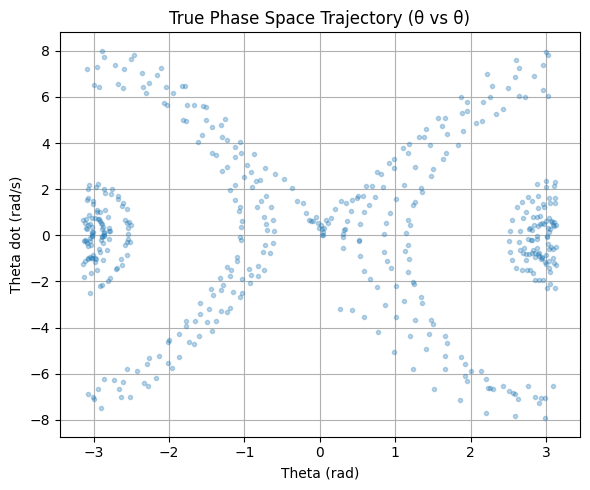

In [9]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================
# 1. Data Collection and Preparation
# ============================

class PendulumDataset(Dataset):
    def __init__(self, num_episodes=100, episode_length=200, img_size=64, transform=None):
        """
        Dataset for pendulum images from OpenAI Gym

        Args:
            num_episodes: Number of episodes to collect
            episode_length: Length of each episode
            img_size: Size to resize images to
            transform: Additional transforms to apply
        """
        self.img_size = img_size
        self.transform = transform

        # Generate synthetic pendulum images
        self.generate_synthetic_pendulum_data(num_episodes, episode_length)

    def generate_synthetic_pendulum_data(self, num_episodes, episode_length):
        """Generate synthetic pendulum data using PIL"""
        print("Generating synthetic pendulum data...")
        self.images = []

        # Create environment to get pendulum dynamics
        env = gym.make('Pendulum-v1')

        # Set up parameters for drawing pendulum
        img_size = self.img_size
        pendulum_length = img_size * 0.4
        center_x, center_y = img_size // 2, img_size // 2

        self.images = []
        self.labels = []

        for episode in tqdm(range(num_episodes)):
            # Reset environment
            obs = env.reset()
            if isinstance(obs, tuple):
                obs = obs[0]  # New API returns (obs, info)

            # Extract theta from observation
            # In Pendulum-v1, obs[0] = cos(theta), obs[1] = sin(theta)
            theta = np.arctan2(obs[1], obs[0])

            for step in range(episode_length):
                # Take random action
                action = env.action_space.sample()

                # Step the environment
                step_result = env.step(action)

                # Handle different Gym API versions
                if len(step_result) == 4:  # Old API
                    obs, reward, done, _ = step_result
                else:  # New API
                    obs, reward, terminated, truncated, _ = step_result
                    done = terminated or truncated

                # Extract theta from observation
                theta = np.arctan2(obs[1], obs[0])
                omega = obs[2]

                # Draw pendulum image
                # Create a blank image
                img = Image.new('RGB', (img_size, img_size), color='white')
                draw = ImageDraw.Draw(img)

                # Calculate pendulum endpoint
                end_x = int(center_x + pendulum_length * np.sin(theta))
                end_y = int(center_y + pendulum_length * np.cos(theta))

                # Draw pendulum rod
                draw.line([(center_x, center_y), (end_x, end_y)], fill='black', width=3)

                # Draw pivot point
                draw.ellipse(
                    [(center_x-5, center_y-5), (center_x+5, center_y+5)],
                    fill='red'
                )

                # Draw bob
                draw.ellipse(
                    [(end_x-8, end_y-8), (end_x+8, end_y+8)],
                    fill='blue'
                )

                # Convert to numpy array
                img_array = np.array(img)

                # Add to dataset
                self.images.append(img_array)
                self.labels.append((theta, omega))

                if done:
                    break

        env.close()
        self.images = np.array(self.images)
        print(f"Dataset created with {len(self.images)} images")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        # Convert to tensor
        img = torch.from_numpy(img).float() / 255.0
        img = img.permute(2, 0, 1)  # Convert to CxHxW format

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(label, dtype=torch.float32)

        return img, label

    def __len__(self):
        return len(self.images)

    # def __getitem__(self, idx):
    #     img = self.images[idx]

    #     # Convert to tensor
    #     img = torch.from_numpy(img).float() / 255.0
    #     img = img.permute(2, 0, 1)  # Convert to CxHxW format

    #     if self.transform:
    #         img = self.transform(img)

    #     return img

# ============================
# 2. VJEPA Architecture
# ============================

class PatchEmbed(nn.Module):
    """
    Image to Patch Embedding
    """
    def __init__(self, img_size=64, patch_size=8, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (B, n_patches, embed_dim)
        return x

class TransformerEncoder(nn.Module):
    """
    Transformer encoder block
    """
    def __init__(self, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            layer = nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=int(embed_dim * mlp_ratio),
                batch_first=True,
                norm_first=True
            )
            self.layers.append(layer)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class MaskingStrategy:
    """
    Handles masked prediction strategies for JEPA/VJEPA
    """
    def __init__(self, num_patches, mask_ratio=0.75, block_size=4):
        self.num_patches = num_patches
        self.mask_ratio = mask_ratio
        self.block_size = block_size

    def random_masking(self, batch_size):
        """Generate random masks for a batch"""
        n_keep = int(self.num_patches * (1 - self.mask_ratio))

        # For each sample, randomly select patches to keep
        noise = torch.rand(batch_size, self.num_patches, device=device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # Determine which patches to keep
        mask = torch.ones([batch_size, self.num_patches], device=device)
        mask[:, :n_keep] = 0
        # Unshuffle to get the mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return mask.bool()  # masked positions are True

    def block_masking(self, batch_size):
        """Generate block-wise masks"""
        grid_size = int(np.sqrt(self.num_patches))

        # Create empty masks
        masks = torch.zeros(batch_size, self.num_patches, device=device)

        for b in range(batch_size):
            # Number of blocks to mask
            n_blocks = int((self.num_patches * self.mask_ratio) / (self.block_size**2))

            # Randomly choose block starting positions
            for _ in range(n_blocks):
                # Choose random top-left corner for block
                h_start = np.random.randint(0, grid_size - self.block_size + 1)
                w_start = np.random.randint(0, grid_size - self.block_size + 1)

                # Mask all patches in this block
                for h in range(h_start, h_start + self.block_size):
                    for w in range(w_start, w_start + self.block_size):
                        patch_idx = h * grid_size + w
                        masks[b, patch_idx] = 1

        return masks.bool()  # masked positions are True

class VJEPA(nn.Module):
    """
    Vision-based Joint Embedding Predictive Architecture
    """
    def __init__(
        self,
        img_size=64,
        patch_size=8,
        in_chans=3,
        embed_dim=768,
        depth=12,
        num_heads=12,
        decoder_embed_dim=512,
        decoder_depth=8,
        decoder_num_heads=16,
        mlp_ratio=4.0,
        prediction_head_dim=384
    ):
        super().__init__()

        # Patch embedding
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim
        )

        # Number of patches
        self.num_patches = self.patch_embed.n_patches

        # Position embeddings
        self.pos_embed = nn.Parameter(
            torch.zeros(1, self.num_patches, embed_dim)
        )

        # Context encoder (f_θ)
        self.context_encoder = TransformerEncoder(
            embed_dim=embed_dim,
            depth=depth,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio
        )

        # Target encoder (g_ϕ)
        self.target_encoder = TransformerEncoder(
            embed_dim=embed_dim,
            depth=depth,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio
        )

        # Predictor network
        self.predictor = nn.Sequential(
            nn.Linear(embed_dim, prediction_head_dim),
            nn.GELU(),
            nn.Linear(prediction_head_dim, embed_dim)
        )

        # Masking strategy
        self.masking = MaskingStrategy(self.num_patches)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        # Initialize position embeddings
        nn.init.normal_(self.pos_embed, std=0.02)

        # Initialize projection layers
        self.apply(self._init_weights_layer)

    def _init_weights_layer(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    # def forward_context(self, imgs, context_mask):
    #     """Process the context (visible) regions"""
    #     # Get patch embeddings
    #     x = self.patch_embed(imgs)

    #     # Add position embeddings
    #     x = x + self.pos_embed

    #     # Get unmasked patches
    #     unmasked_indices = ~context_mask
    #     x_unmasked = x[unmasked_indices].reshape(imgs.shape[0], -1, x.shape[-1])

    #     # Encode context
    #     context_feats = self.context_encoder(x_unmasked)

    #     return context_feats
    def forward_context(self, imgs, context_mask):
      """Process the context (visible) regions"""
      # Get patch embeddings
      x = self.patch_embed(imgs)  # [B, num_patches, embed_dim]

      # Add positional embeddings
      x = x + self.pos_embed  # [B, num_patches, embed_dim]

      B, N, D = x.shape
      unmasked_indices = ~context_mask  # [B, num_patches]

      # Collect unmasked patches per sample
      x_unmasked = []

      for i in range(B):
          patches = x[i][unmasked_indices[i]]  # [num_unmasked_i, D]

          # Pad to the max number of patches in the batch
          num_unmasked = patches.shape[0]
          padded = F.pad(patches, (0, 0, 0, N - num_unmasked))  # [N, D]
          x_unmasked.append(padded)

      x_unmasked = torch.stack(x_unmasked)  # [B, N, D]

      # Optionally, create attention masks if Transformer should ignore padded tokens

      # Encode context
      context_feats = self.context_encoder(x_unmasked)  # [B, N, D]

      return context_feats


    def forward_target(self, imgs, target_mask):
        """Process the target (masked) regions"""
        # Get patch embeddings
        x = self.patch_embed(imgs)  # [B, num_patches, embed_dim]

        # Add positional embeddings
        x = x + self.pos_embed

        B, N, D = x.shape
        masked_indices = target_mask  # [B, num_patches]

        x_masked = []

        for i in range(B):
            patches = x[i][masked_indices[i]]  # [num_masked_i, D]

            # Pad to full length N
            num_masked = patches.shape[0]
            padded = F.pad(patches, (0, 0, 0, N - num_masked))  # [N, D]
            x_masked.append(padded)

        x_masked = torch.stack(x_masked)  # [B, N, D]

        # Encode masked regions (targets)
        target_feats = self.target_encoder(x_masked)

        return target_feats


    def forward(self, imgs):
        """
        Forward pass of VJEPA

        Args:
            imgs: Batch of images [B, C, H, W]

        Returns:
            loss: VJEPA loss value
            pred: Predicted embeddings
            target: Target embeddings
        """
        B = imgs.shape[0]

        # Generate masks for context and target
        context_mask = self.masking.block_masking(B)
        target_mask = self.masking.random_masking(B)

        # Ensure context and target don't overlap
        overlap_mask = context_mask & target_mask
        target_mask = target_mask & ~overlap_mask

        # Forward pass through context encoder
        context_feats = self.forward_context(imgs, context_mask)

        # Forward pass through target encoder
        with torch.no_grad():  # Stop gradient for target encoder
            target_feats = self.forward_target(imgs, target_mask)

        # Generate predictions from context
        pred = self.predictor(context_feats)

        # Compute loss
        loss = F.mse_loss(pred, target_feats)

        return loss, pred, target_feats

# ============================
# 3. Training Function
# ============================

def train_vjepa(model, theta_head, lnn_net,          #  ← vec_field → lnn_net
                train_loader, optimizer,
                num_epochs=100, log_interval=10,
                lambda_phys=1e-3, lambda_sup=1e-2):
    """
    Train VJEPA with an additional **Lagrangian-NN physics loss**.
    """
    model.train(); theta_head.train(); lnn_net.train()
    losses = []

    print("Starting training…")
    for epoch in range(num_epochs):
        epoch_loss = 0.0

        for step, (imgs, labels) in enumerate(
                tqdm(train_loader, unit="batch",
                     desc=f"Epoch {epoch+1}/{num_epochs}")):

            imgs, labels = imgs.to(device), labels.to(device)   # labels = (θ_true , ω_true)

            # ─── 1 · JEPA reconstruction loss ───────────────────────
            loss_jepa, _, _ = model(imgs)

            # ─── 2 · Latent → (θ̂ , ω̂)  (trainable) ────────────────
            lat = model.patch_embed(imgs) + model.pos_embed       # [B,N,D]
            lat = model.context_encoder(lat)                      # [B,N,D]
            z   = lat.mean(dim=1)                                 # [B,D]
            theta_pred, omega_pred = theta_head(z).split(1, dim=1)  # [B,1] each

            # ─── 3 · LNN physics loss  (Euler–Lagrange residual) ───
            q_batch = theta_pred.unsqueeze(1)   # (B,1,1)  add time axis
            v_batch = omega_pred.unsqueeze(1)   # (B,1,1)
            phys_loss = lnn_net.lagrangian_residual(q_batch, v_batch, dt=1.0)

            # optional direct θ supervision
            theta_true = labels[:, 0:1]
            sup_loss   = F.mse_loss(theta_pred, theta_true)

            # ─── 4 · Total objective & optimisation ────────────────
            loss = loss_jepa + lambda_phys * phys_loss + lambda_sup * sup_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if step % log_interval == 0:
                tqdm.write(f"step {step:04d} | "
                           f"jepa {loss_jepa.item():.4f} | "
                           f"phys {phys_loss.item():.4f}")

        avg = epoch_loss / len(train_loader)
        losses.append(avg)
        print(f"Epoch {epoch+1} complete — avg loss {avg:.4f}")

    return losses

# ============================
# 4. Visualization Functions
# ============================
def visualize_reconstructions(model, dataset, num_samples=5):
    """Visualize original images and their reconstructions"""
    model.eval()

    # Create a dataloader with batch size equal to num_samples
    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
    imgs, _ = next(iter(loader))  # <-- FIXED: unpack the tuple
    imgs = imgs.to(device)

    # Get reconstructions
    with torch.no_grad():
        # Generate masks
        B = imgs.shape[0]
        context_mask = model.masking.block_masking(B)
        target_mask = model.masking.random_masking(B)

        # Ensure no overlap
        overlap_mask = context_mask & target_mask
        target_mask = target_mask & ~overlap_mask

        # Get features
        context_feats = model.forward_context(imgs, context_mask)
        pred = model.predictor(context_feats)

    # Visualize the results
    plt.figure(figsize=(12, 4 * num_samples))

    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 3, i * 3 + 1)
        img = imgs[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title("Original")
        plt.axis('off')

        # Masked image (context)
        plt.subplot(num_samples, 3, i * 3 + 2)
        masked_img = imgs[i].clone().cpu()

        grid_size = int(np.sqrt(model.num_patches))
        mask_reshaped = context_mask[i].reshape(1, 1, grid_size, grid_size).float()
        mask_upsampled = F.interpolate(
            mask_reshaped,
            size=(imgs.shape[2], imgs.shape[3]),
            mode='nearest'
        ).squeeze()

        for c in range(3):
            masked_img[c][mask_upsampled.bool()] = 0.5  # Gray out masked areas

        plt.imshow(masked_img.permute(1, 2, 0).numpy())
        plt.title("Context (Visible Regions)")
        plt.axis('off')

        # Target image (highlight predicted regions)
        plt.subplot(num_samples, 3, i * 3 + 3)
        target_img = imgs[i].clone().cpu()

        target_mask_reshaped = target_mask[i].reshape(1, 1, grid_size, grid_size).float()
        target_mask_upsampled = F.interpolate(
            target_mask_reshaped,
            size=(imgs.shape[2], imgs.shape[3]),
            mode='nearest'
        ).squeeze()

        for c in range(3):
            if c == 0:  # Red channel
                target_img[c][target_mask_upsampled.bool()] = 1.0
            else:
                target_img[c][target_mask_upsampled.bool()] = 0.3

        plt.imshow(target_img.permute(1, 2, 0).numpy())
        plt.title("Target (Predicted Regions)")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('vjepa_reconstructions.png')
    plt.show()


def plot_training_loss(losses):
    """Plot training loss over epochs"""
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('VJEPA Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig('vjepa_training_loss.png')
    plt.show()

# ============================
# 5. Main Execution
# ============================

def main():
    # ───────────────────────────
    # 0 · Configuration
    # ───────────────────────────
    batch_size          = 32
    img_size            = 64
    patch_size          = 8
    embed_dim           = 384      # smaller for speed
    depth               = 6
    num_heads           = 6
    prediction_head_dim = 192
    learning_rate       = 1e-4
    num_epochs          = 10

    # ───────────────────────────
    # 1 · Dataset & loader
    # ───────────────────────────
    dataset      = PendulumDataset(num_episodes=50,
                                   episode_length=100,
                                   img_size=img_size)
    train_loader = DataLoader(dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=0)

    # ───────────────────────────
    # 2 · V-JEPA backbone
    # ───────────────────────────
    model = VJEPA(
        img_size       = img_size,
        patch_size     = patch_size,
        in_chans       = 3,
        embed_dim      = embed_dim,
        depth          = depth,
        num_heads      = num_heads,
        decoder_embed_dim = embed_dim // 2,
        decoder_depth  = 4,
        decoder_num_heads = num_heads,
        mlp_ratio      = 4.0,
        prediction_head_dim = prediction_head_dim
    ).to(device)

    # ───────────────────────────
    # 3 · Latent → (θ, ω) head
    # ───────────────────────────
    theta_head = torch.nn.Linear(embed_dim, 2, bias=True).to(device)

    # ───────────────────────────
    # 4 · Lagrangian-NN physics net
    #     (uses helper class defined earlier)
    # ───────────────────────────
    lnn_net = LNN(input_dim=2, hidden_dim=256).to(device)

    # ───────────────────────────
    # 5 · Optimiser (all params)
    # ───────────────────────────
    optimizer = optim.AdamW(
        list(model.parameters()) +
        list(theta_head.parameters()) +
        list(lnn_net.parameters()),
        lr=learning_rate
    )

    # ───────────────────────────
    # 6 · Training
    # ───────────────────────────
    losses = train_vjepa(
        model, theta_head, lnn_net,
        train_loader, optimizer,
        num_epochs=num_epochs
    )

    plot_training_loss(losses)
    visualize_reconstructions(model, dataset)

    # save checkpoint
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }, "vjepa_pendulum_final.pt")

    print("Training completed!")
    analyze_vjepa_latent_phase_relation(model, dataset)
    plot_true_phase_space(dataset)
    # plot_energy_conservation(dataset)   # uncomment if desired


if __name__ == "__main__":
    main()